In [ ]:
from selenium import webdriver
from bs4 import BeautifulSoup
import requests
from selenium.webdriver.common.by import By
from tqdm import tqdm

In [1]:
import time
import csv
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

### Let's do web scrapping of afisha.ru: we need to collect info about restaurants in Moscow.

#### Firstly, we'll collect the restaurants links by going through all the pages with Selenium.

In [50]:
base_url = "https://www.afisha.ru"
url = f"{base_url}/msk/restaurants/restaurant_list/"

options = webdriver.ChromeOptions()
# options.add_argument('--headless')
driver = webdriver.Chrome(options=options)

driver.get(url)
time.sleep(7)

all_links = set()  #We need to use set to avoid repeat links

while True:
    soup = BeautifulSoup(driver.page_source, "html.parser")
    for a in soup.find_all("a"):
        if "href" in a.attrs and a["href"].startswith("/msk/restaurant"): #Search only links starts with /msk/restaurant
            all_links.add(a["href"])

    try:
        next_button = driver.find_element(By.CLASS_NAME, 'Pagination_pagination-next__rtqsZ')#try to click next page button
        next_button.click()
        time.sleep(5)
    except Exception as e:
        try:
            close_button = driver.find_element(By.CLASS_NAME, 'popmechanic-close')#unexpectedly a banner pops up on the site, try to close it, as it covers the usual page layout
            close_button.click()
            time.sleep(2)

            next_button = driver.find_element(By.CLASS_NAME, 'Pagination_pagination-next__rtqsZ')#try to click next page button again
            next_button.click()
            time.sleep(5)
        except Exception as inner_e:
            print("There are no more pages:", inner_e)
            break

driver.quit()

#### Collected links are combined into a DataFrame to be shared with other group members for gathering information about restaurants.

In [ ]:
#adding base url to links
full_links = [base_url + link for link in all_links]
all_links_list = list(full_links)

df = pd.DataFrame(all_links_list, columns=['Link'])
df.to_csv('resto_links.csv', index=False)

print(f"We saved {len(all_links_list)} links in 'rest_links.csv'")

We saved 11957 links in 'rest_links.csv'


#### To collect information about restaurants in Moscow, we selected the following characteristics:

* title: name of the restaurant
* rating: the establishment's rating on the website
* address: restaurant address
* metro: the nearest metro station to the restaurant
* avg_check: average check at the establishment
* breakfast: availability of a breakfast menu
* business_lunch: availability of a business lunch menu
* delivery: availability of delivery services
* parking: availability of parking
* catering: availability of catering services
* banquets: whether banquets are held
* telephone: restaurant phone number
* site: restaurant website
* restaurant_type: type of establishment or cuisine
* open_hours: opening hours
* positive_reviews: number of positive reviews on the website
* negative_reviews: number of negative reviews on the website


#### We extract the required tags and their content from each page and then form a DataFrame

In [27]:
# define function for collecting information about restaurants reviews
def get_reviews_count(button):
    content_div = button.find('div', class_='Button_button__content___D2b_')
    if content_div:
        counter_span = content_div.find('span', class_='DefaultTag_button__counter__64UpQ')
        if counter_span:
            return int(counter_span.text)
    return 0

In [ ]:

options = webdriver.ChromeOptions()
options.add_argument('--headless')
driver = webdriver.Chrome(options=options)

with open('resto_links.csv', 'w', encoding='utf-8-sig', newline='') as d:
    file_writer =  csv.writer(d, delimiter = ";")
    file_writer.writerow(["title", "rating", "address", "metro", "avg_check", "breakfast", "business_lunch", "delivery", "parking", "catering", "banquets", "telephone", "site", "restaurant_type", "open_hours", "positive_reviews", "negative_reviews"]) 

with open('for_vera_2.csv','r') as f:
    all_links = f.readlines()

# parsing data with progress bar and remaining time
for i, link in enumerate(tqdm(all_links, desc="Links processing", unit="link", dynamic_ncols=True)):
    try:

        driver.get(link)
        driver.implicitly_wait(10)

        soup = BeautifulSoup(driver.page_source, "html.parser")

            
        name = soup.find('span',class_ = "Title_header__SIloF").text
        rank = soup.find('div',class_ = "RestaurantCover_rating-wrapper__CTNts")
        if rank!=None:
            estimate = rank.text
        else:
            estimate = 0
        adress = soup.find('div', class_="SectionTitle_wrapper__nAAJ0 RestaurantExtraInfo_address__aJsK2").text
        metro = soup.find_all('ul', class_="RestaurantExtraInfo_metro-list__KTBX3")
        metro_=[]
        for i in metro:
            for j in i.find_all('span', class_="Text_text__e9ILn"):
                metro_ += [j.text]
        s = ''       
        all = soup.find_all('div',class_ = "RestaurantExtraInfo_table__l34_J")
        for i in all:
            for j in i.find_all('span', class_="Text_text__e9ILn"):
                s += j.text + ','
            tot =s.split(',')[1:len(s):2]   
        bill = tot[0] 
        brekfast = tot[1]
        business =  tot[2]
        delivery = tot[3]
        parking = tot[4]
        keit = tot[5]
        feast = tot[6] 
        phone_num = tot[7]
        site_ = tot[8] 
        type_all = []
        type_ = soup.find_all('div',class_ = "RestaurantExtraInfo_tag__BqQ7e")
        for i in type_:
            for j in i.find_all('div', class_="Button_button__content___D2b_"):
                type_all +=[j.text] 
        work = soup.find_all('div',class_ = "RestaurantCover_content-wrapper__72Dox")
        for i in work:
            for j in i.find_all('span', class_="Text_text__e9ILn"):
                e = j          
        open_ = e.text.strip('Открыто c')    

        filters_div = soup.find('div', class_='FiltersReview_filters__7E8qs')
        positive_reviews = 0
        negative_reviews = 0

        if filters_div:
            buttons = filters_div.find_all('button', class_='Button_button__j_Rc9')
            for button in buttons:
                content_div = button.find('div', class_='Button_button__content___D2b_')
                if content_div:
                    text = content_div.text
                    if 'Положительные' in text:
                        positive_reviews = get_reviews_count(button)
                    elif 'Отрицательные' in text:
                        negative_reviews = get_reviews_count(button)

                    
        with open('data.csv', 'a', encoding='utf-8-sig', newline='') as d:
            file_writer =  csv.writer(d, delimiter = ";")
            file_writer.writerow([name, estimate, adress, metro_, bill, brekfast ,business ,delivery ,parking ,keit ,feast ,phone_num , site_, type_all, open_, positive_reviews, negative_reviews])

    except TypeError:
        pass
    except Exception as e:
        tqdm.write(f"Link processing error {link}: {e}")
driver.quit()

#### Creating DataFrame
Using CSV-file with whole data set

In [81]:
df = pd.read_csv('big_data.csv', delimiter=';')

In [82]:
df.head()

,title,rating,address,metro,avg_check,breakfast,business_lunch,delivery,parking,catering,banquets,telephone,site,restaurant_type,open_hours,positive_reviews,negative_reviews
0,One Price Coffee,0,"Москва, Автозаводская, 18, ТРЦ «Ривьера», 1 этаж",['Автозаводская'],Нет,Нет,Нет,Нет,Есть,Нет,Нет,+7 (495) 015 31 50,http://onepricecoffee.com,"['Сэндвичи', 'Кофейни']",08:00 до 22:00,0,0
1,Rioba,0,"Москва, Маршала Прошлякова, 14, ТЦ Metro Cash ...",['Строгино'],До 700 ₽,Нет,Нет,Нет,Есть,Нет,Нет,+7 926 123 78 78,Нет,"['Кафе', 'Кофейни']",09:00 до 21:00,0,0
2,Мята Lounge,0,"Москва, Костромская, 17",['Бибирево'],700–1700 ₽,Нет,Нет,Нет,Есть,Нет,Нет,+7 (495) 410 13 31,http://vk.com/myata_moscow_bibirevo,"['Европейская кухня', 'Паровые коктейли', 'Сэн...",14:00 до 05:00,0,0
3,Farsh,0,"Москва, просп. Вернадского, 86а, ТРЦ Avenue So...",['Юго-Западная'],700–1700 ₽,Есть,Нет,Есть,Есть,Нет,Нет,+7 (495) 542 44 11,http://farshburger.ru,"['Американская кухня', 'Бургеры', 'Стейки', 'К...",10:00 до 23:00,0,0
4,Лакшми и Ко,0,"Москва, Херсонская, 43, корп. 3","['Калужская', 'Воронцовская']",До 700 ₽,Нет,Нет,Нет,Есть,Нет,Нет,+7 968 951 66 71,Нет,"['Европейская кухня', 'Кафе']",08:00 до 19:00,0,0


In [83]:
# get info about number of data coloumns and its type
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12434 entries, 0 to 12433
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   title             12434 non-null  object
 1   rating            12434 non-null  object
 2   address           12434 non-null  object
 3   metro             12434 non-null  object
 4   avg_check         12434 non-null  object
 5   breakfast         12434 non-null  object
 6   business_lunch    12434 non-null  object
 7   delivery          12434 non-null  object
 8   parking           12434 non-null  object
 9   catering          12434 non-null  object
 10  banquets          12434 non-null  object
 11  telephone         12434 non-null  object
 12  site              12434 non-null  object
 13  restaurant_type   12434 non-null  object
 14  open_hours        12434 non-null  object
 15  positive_reviews  12434 non-null  int64 
 16  negative_reviews  12434 non-null  int64 
dtypes: int64(2),

In [4]:
df.shape

(12434, 17)

#### Allmost all of the coloumns have object type. We need to convert some columns to categorical or numeric variables for further data analysis. Also in this step we clean the data from gaps and duplicates and create new variables.

#### Firtly, we fix NaN values and duplicates by function clean_data

In [84]:
def clean_data(
        data_frame: pd.DataFrame
) -> pd.DataFrame:
    """
    Cleans the DataFrame by removing duplicates and handling missing values if its exist.

        :param data_frame: pd.DataFrame

        :return: pd.DataFrame
    """

    # 1. Remove full duplicates and duplicates by title+adress
    data_frame.drop_duplicates(inplace=True)
    data_frame.drop_duplicates(subset=['title', 'address'], inplace=True)

    # 2. Remove rows with empty addresses(we cannot indificate restaurant only by title because there are many chain restaurants)
    # Remove rows with empty metro stations
    data_frame = data_frame[data_frame['address'] != '']
    data_frame = data_frame[data_frame['metro'] != '[]']

    # 3. Remove rows with any missing values (NaN)
    data_frame.dropna(how='any', inplace=True)
    if 'avg_check' in data_frame.columns:
        # Получаем значения столбца 'avg_check', исключая "Нет"
        avg_check_values = data_frame.loc[data_frame['avg_check'] != 'Нет', 'avg_check']

        if not avg_check_values.empty:
            # Находим наиболее часто встречающееся значение без использования Counter
            most_common_value = avg_check_values.value_counts().index[0]

            # Заменяем "Нет" на наиболее частое значение
            data_frame['avg_check'] = data_frame['avg_check'].replace('Нет', most_common_value)
    return data_frame
df = clean_data(data_frame=df)

#### Fixing rating column: this column contains unnecessary words in addition to the numeric value of the rating.

In [85]:
def fix_rating_column(
        data_frame: pd.DataFrame
) -> pd.DataFrame:
    '''
        There are cells with the pattern "n отзывов", they are replaced by '0'.
        The rating column is converted to the float (numeric) type.
        The average value of the review is set to 0.

        :param data_frame: pd.DataFrame

        :return: pd.DataFrame
    '''

    for index, row in data_frame.iterrows():
        if '.' in row['rating'] and 'отз' in row['rating']:
            data_frame.loc[index, 'rating'] = row['rating'].split(' ')[0][:2]
        elif 'отз' in row['rating']:
            data_frame.loc[index, 'rating'] = '1.0' # there was no such rating before

    data_frame['rating'] = pd.to_numeric(data_frame['rating'])
    global mean_rating
    mean_rating = round(data_frame[data_frame['rating'] > 1.0]['rating'].mean(), 2)
    
    for index, row in data_frame.iterrows():
        if row['rating'] in [1.0]:
            data_frame.loc[index, 'rating'] = mean_rating

    return data_frame

df = fix_rating_column(data_frame=df)

#### transform_information_columns 
* function convert breakfast, business_lunch, delivery, parking,catering, banquets, telephone columns to the categorized view depending on the presence or absence of the service (0 - no, 1 - yes). 
* Also function convert avg_check coloumn to categorical view (1 - to 700 rub, 2 - 700-1700 rub, 3 - 1700-3000, 4 - more than 3000 rub). 
* New feature: if the restaurant is situated in the city center by metro stations.

In [86]:
def transform_information_columns(
        data_frame: pd.DataFrame
) -> pd.DataFrame:
    '''
        Changing breakfast, business_lunch, delivery, parking, catering, banquets columns
        to 0 or 1. Added column is_city_center (0 or 1) to see is restaurant in garden ring in Moscow.

        :param data_frame: pd.DataFrame

        :return: pd.DataFrame
    '''
    station_metro = 'Цветной бульварТверскаяЧеховскаяБоровицкаяаяПолянкаДобрынинскаяСерпуховскаяМаяковскаяТеатральнаяНовокузнецкаяПавелецкаяПушкинскаяКузнецкий мостКитай-городТаганскаяМарксистскаяСмоленскаяАрбатскаяАлександровский садПлощадь РеволюцииЧкаловскаяКурскаяПарк культурыКропоткинскаяБиблиотека им. ЛенинаОхотный РядЛубянкаКрасные воротаЧистые прудыКрасные воротаОктябрьскаяТретьяковскаяТургеневскаяСухаревскаяПроспект МираТрубнаяСретенский бульвар' 
    data_frame['breakfast'] = (data_frame['breakfast'] =='Есть').astype(int)
    data_frame['business_lunch'] = (data_frame['business_lunch'] =='Есть').astype(int)
    data_frame['delivery'] = (data_frame['delivery'] =='Есть').astype(int)
    data_frame['parking'] = (data_frame['parking'] =='Есть').astype(int)
    data_frame['catering'] = (data_frame['catering'] =='Есть').astype(int)
    data_frame['banquets'] = (data_frame['banquets'] =='Есть').astype(int)

    sites=list(data_frame['site'].values)
    sites1=[]
    for i in range(len(sites)):
        if sites[i].startswith('http://'):
            sites1+=[1]
        else:
            sites1+=[0]       

    data_frame['site'] = sites1

    telephones=list(data_frame['telephone'].values)
    telephone1=[]
    for i in range(len(telephones)):
        if telephones[i].startswith('+7'):
            telephone1+=[1]
        else:
            telephone1+=[0]   
    data_frame['telephone'] = telephone1     

    #data_frame.loc[data_frame['avg_check'] =='Нет', 'avg_check'] = 0   

    avg = list(data_frame['avg_check'].values)
    avg1=[]
    for i in range(len(avg)):
        if avg[i].startswith('До 7'):
            avg1+=[1]
        elif avg[i].startswith('70'):
            avg1+=[2]
        elif avg[i].startswith('170'):
            avg1+=[3]
        elif avg[i].startswith('Бо'):
            avg1+=[4]        
        else:
            avg1+=[0]   
    data_frame['avg_check'] = avg1
    metros = list(data_frame['metro'].values)
    metro1=[]
    metro2=[]
    for i in metros:
        metro1 += [i[2:len(i)-2].split(',')]
    for i in range(len(metro1)):
        if metro1[i][0] in station_metro:
            metro2 +=[1]
        else:
            metro2 +=[0] 
    data_frame['is_city_center']=metro2     

    return data_frame

df = transform_information_columns(data_frame=df)

#### Separating open_hours column: function gets open time and close time in time format from string with open hours.

In [87]:
def separate_opened_dates(
        data_frame: pd.DataFrame
) -> pd.DataFrame:
    '''
        There is "hh:mm до hh:mm" format in open_hours column.
        It need to separate this column to opened_from_dttm and opened_to_dttm
        and correct mistakes.

        :param data_frame: pd.DataFrame

        :return: pd.DataFrame
    '''

    for index, row in data_frame.iterrows():
        if ' до ' not in row['open_hours']:
            data_frame.loc[index, 'open_hours'] = '10:00 до 22:00' # change cells with mistakes to usual open-close time '10:00 до 22:00'
    
    for index, row in data_frame.iterrows():
        open_from_to = row['open_hours'].split(' до ')
        data_frame.loc[index, 'opened_from_dttm'] = datetime.time(datetime.strptime(open_from_to[0], '%H:%M'))
        data_frame.loc[index, 'opened_to_dttm'] = datetime.time(datetime.strptime(open_from_to[1], '%H:%M'))
    
    data_frame = data_frame.drop(columns=['open_hours'])
    return data_frame
    

df = separate_opened_dates(data_frame=df)

#### Sorting review and finding good restaurants 
* New feature: if there are more positive reviews than negative ones and the rating is more than 8, then write 1 to the new top_restaurant column.

In [88]:
def sorting_review(
        data_frame: pd.DataFrame
) -> pd.DataFrame:
    '''
        If there are more positive reviews than negative ones 
        and the rating is more than 8, 
        then write 1 to the new top_restaurant column.

        :param data_frame: pd.DataFrame

        :return: pd.DataFrame
    '''

    top_rest = []
    pos = data_frame['positive_reviews'].values
    neg = data_frame['negative_reviews'].values
    ran = data_frame['rating'].values

    for i in range(len(pos)):
        if (pos[i]>=neg[i]) and ran[i]>=8:
            top_rest += [1]
        else:
            top_rest += [0]  
    data_frame['top_restaurant']= top_rest
    return data_frame

df = sorting_review(data_frame=df)

In [89]:
df.head()

,title,rating,address,metro,avg_check,breakfast,business_lunch,delivery,parking,catering,banquets,telephone,site,restaurant_type,positive_reviews,negative_reviews,is_city_center,opened_from_dttm,opened_to_dttm,top_restaurant
0,One Price Coffee,0.0,"Москва, Автозаводская, 18, ТРЦ «Ривьера», 1 этаж",['Автозаводская'],1,0,0,0,1,0,0,1,1,"['Сэндвичи', 'Кофейни']",0,0,0,08:00:00,22:00:00,0
1,Rioba,0.0,"Москва, Маршала Прошлякова, 14, ТЦ Metro Cash ...",['Строгино'],1,0,0,0,1,0,0,1,0,"['Кафе', 'Кофейни']",0,0,0,09:00:00,21:00:00,0
2,Мята Lounge,0.0,"Москва, Костромская, 17",['Бибирево'],2,0,0,0,1,0,0,1,1,"['Европейская кухня', 'Паровые коктейли', 'Сэн...",0,0,0,14:00:00,05:00:00,0
3,Farsh,0.0,"Москва, просп. Вернадского, 86а, ТРЦ Avenue So...",['Юго-Западная'],2,1,0,1,1,0,0,1,1,"['Американская кухня', 'Бургеры', 'Стейки', 'К...",0,0,0,10:00:00,23:00:00,0
4,Лакшми и Ко,0.0,"Москва, Херсонская, 43, корп. 3","['Калужская', 'Воронцовская']",1,0,0,0,1,0,0,1,0,"['Европейская кухня', 'Кафе']",0,0,0,08:00:00,19:00:00,0


In [97]:
df.describe()

,rating,avg_check,breakfast,business_lunch,delivery,parking,catering,banquets,telephone,site,positive_reviews,negative_reviews,is_city_center,top_restaurant
count,10763.000000,10763.000000,10763.000000,10763.000000,10763.000000,10763.000000,10763.000000,10763.000000,10763.000000,10763.000000,10763.000000,10763.000000,10763.000000,10763.000000
mean,0.790510,1.655393,0.215646,0.241940,0.454241,0.789650,0.092632,0.317198,0.923534,0.618694,0.071541,0.029267,0.088265,0.015330
std,2.217652,0.802272,0.411289,0.428278,0.497925,0.407576,0.289930,0.465407,0.265754,0.485730,0.802275,0.202149,0.283694,0.122869
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
max,9.200000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,62.000000,6.000000,1.000000,1.000000


<Axes: >

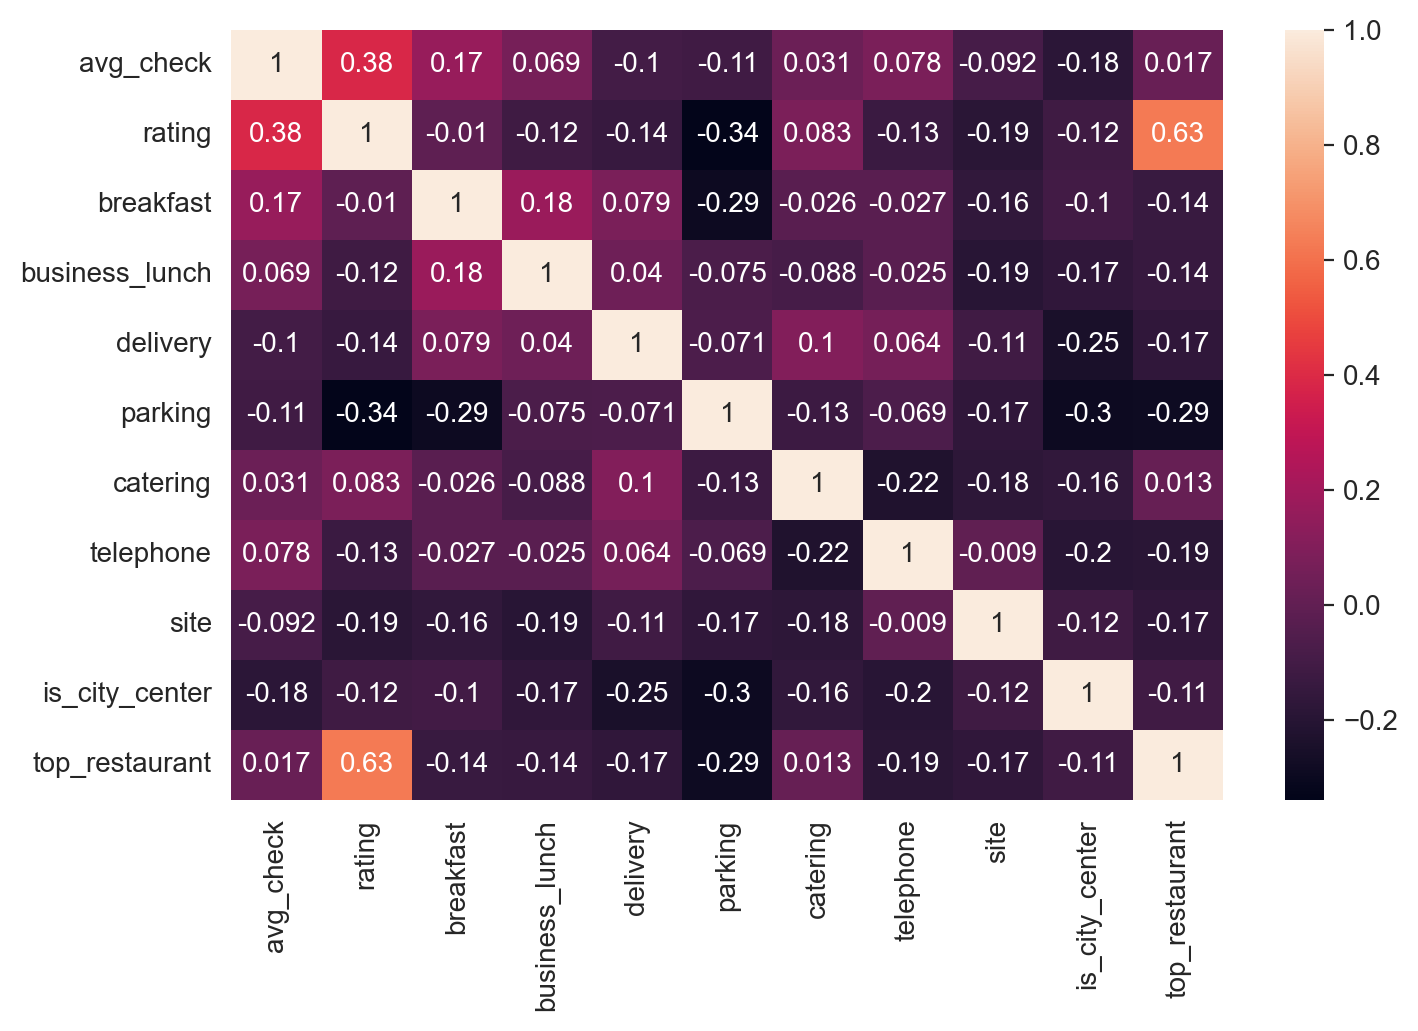

In [96]:
#график корреляции числовых величин

d_cor = dg[['avg_check','rating' , 'breakfast', 'business_lunch', 'delivery', 'parking', 'catering','telephone', 'site', 'is_city_center','top_restaurant']].corr()
sns.heatmap(d_cor.corr(), annot = True)

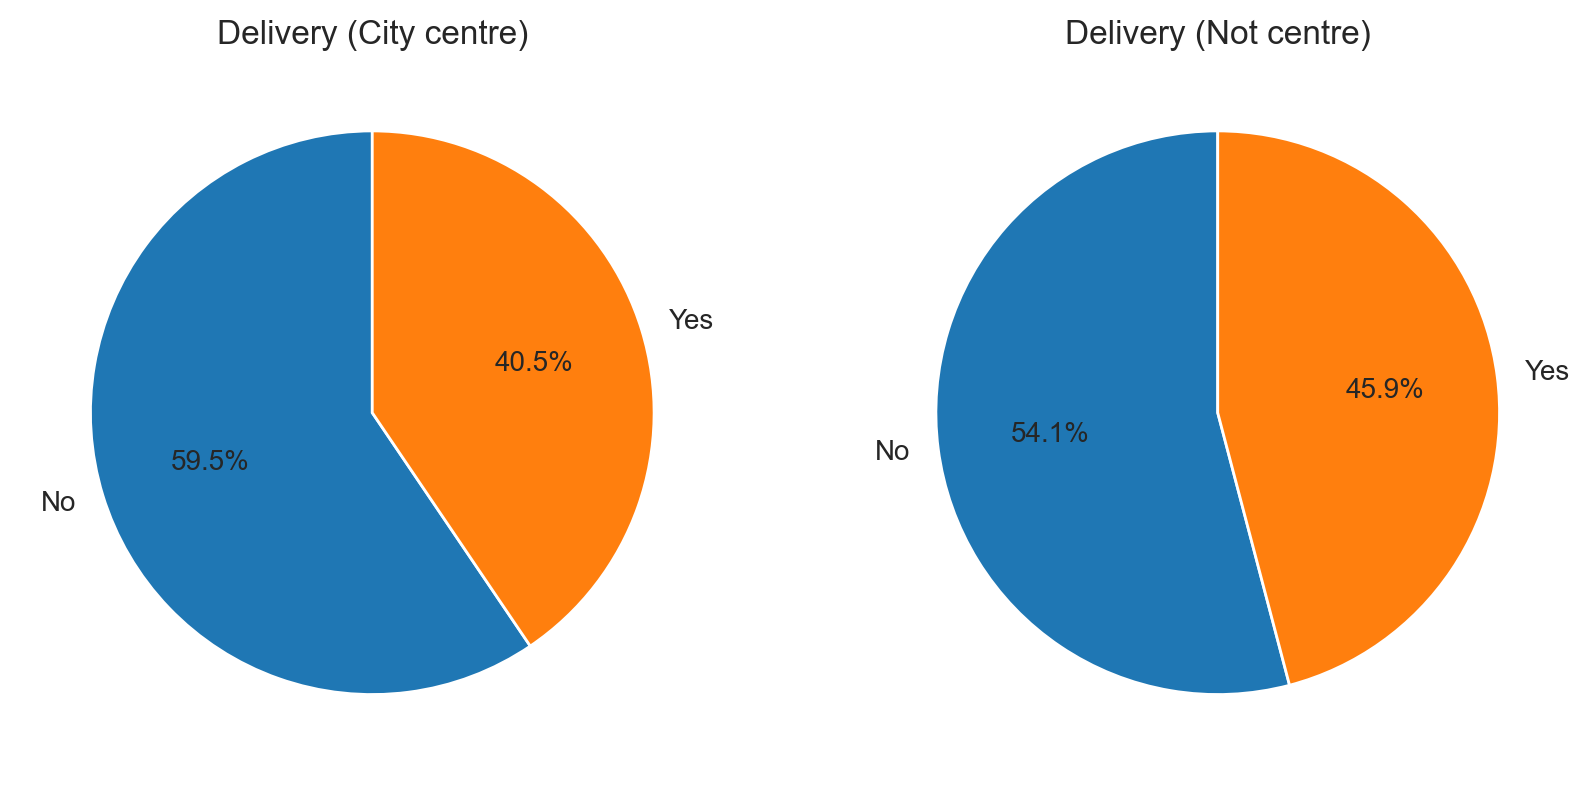

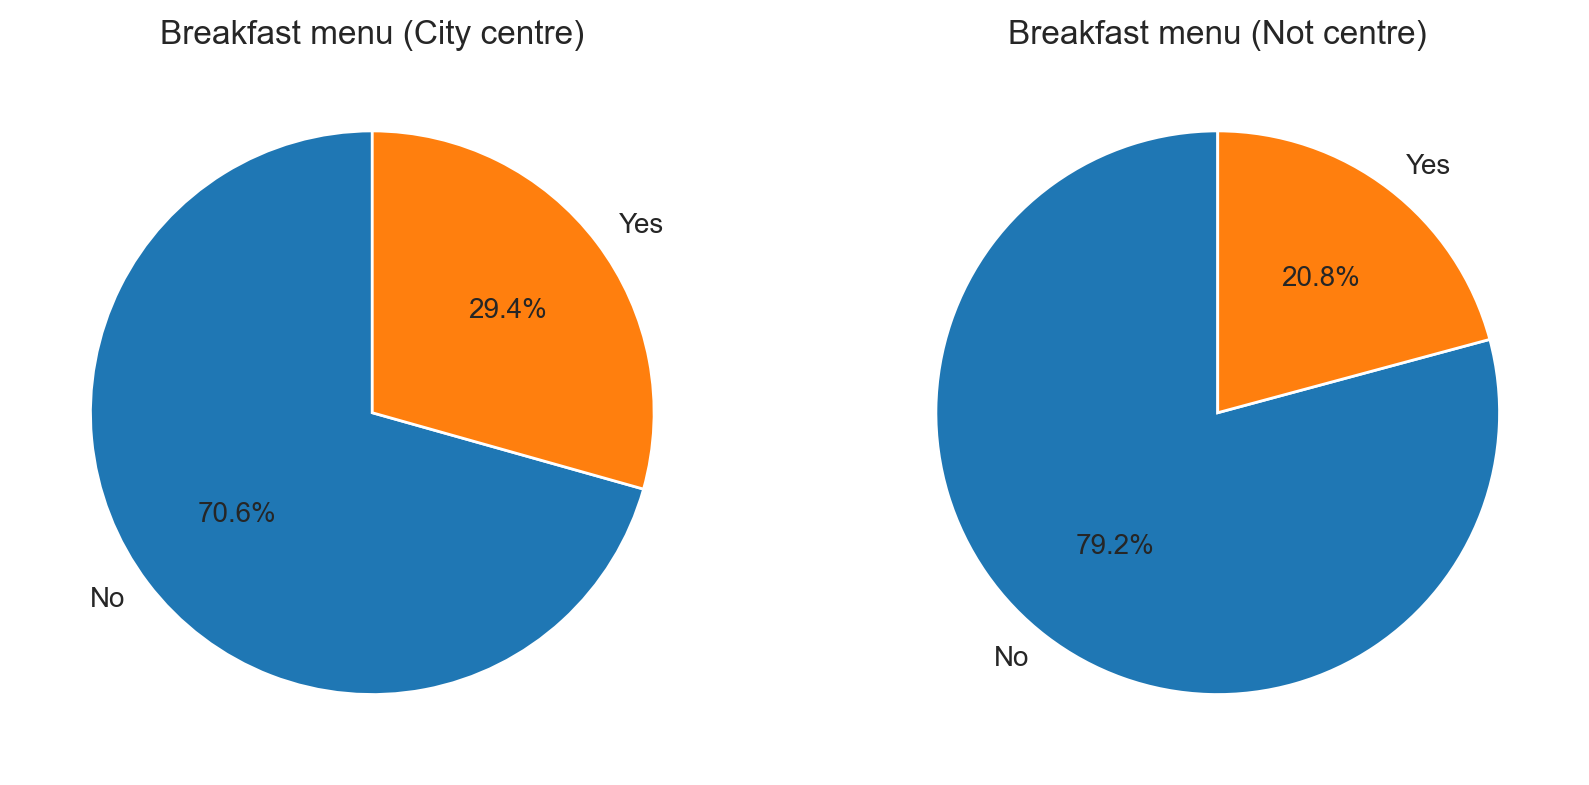

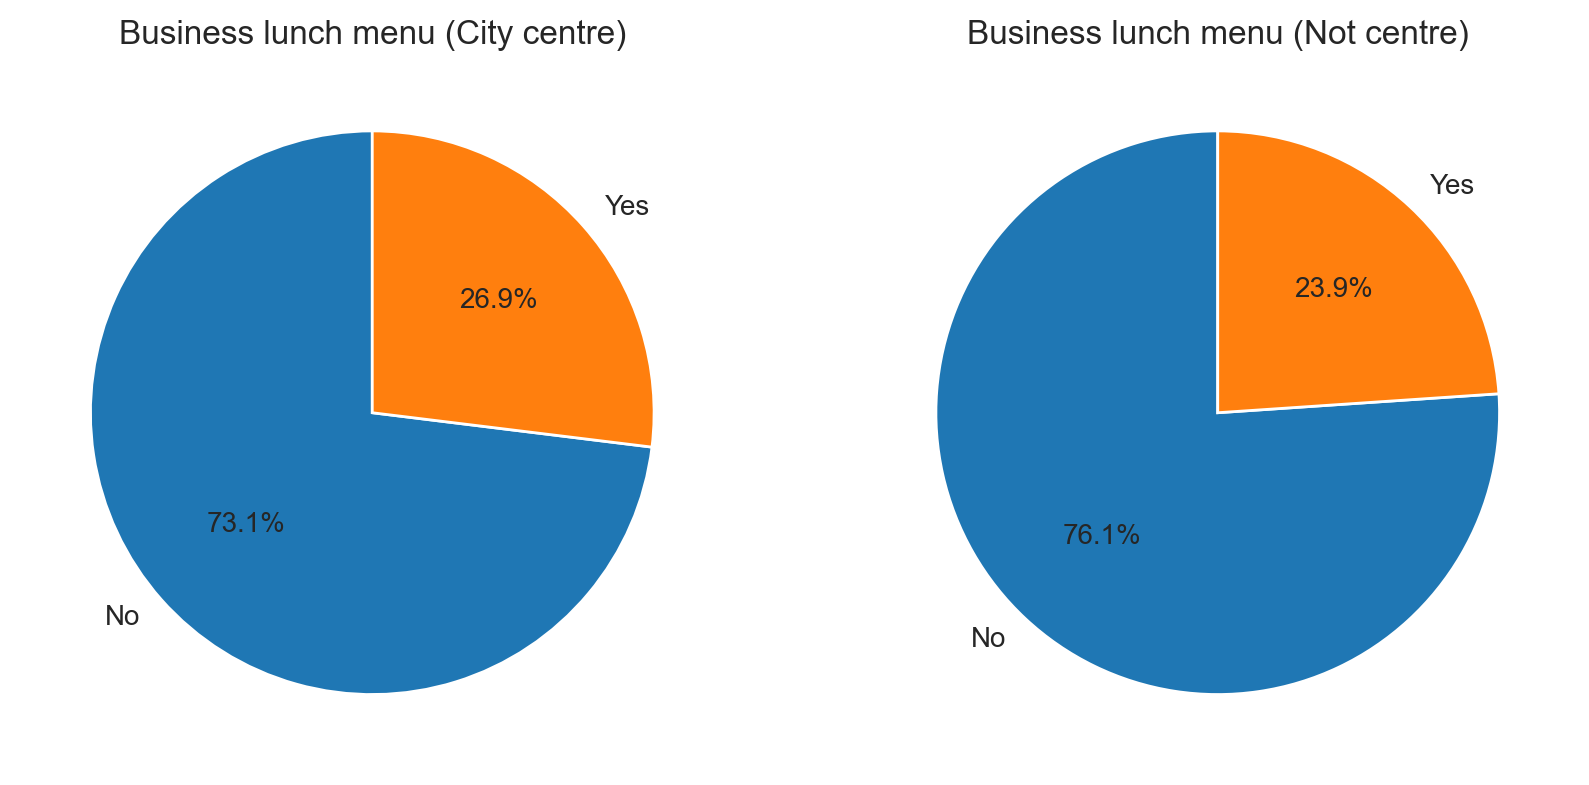

In [99]:
def plot_pie_charts(df, column, titles):
    """Строит две круговые диаграммы рядом для заданного столбца."""
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Фильтрация и построение для центра
    subset_center = df[df['is_city_center'] == 1]
    counts_center = subset_center[column].value_counts(normalize=True) * 100
    labels_center = ['Yes' if idx == 1 else 'No' for idx in counts_center.index]
    axes[0].pie(counts_center, labels=labels_center, autopct='%1.1f%%', startangle=90)
    axes[0].set_title(titles[0])

    # Фильтрация и построение для не центра
    subset_not_center = df[df['is_city_center'] == 0]
    counts_not_center = subset_not_center[column].value_counts(normalize=True) * 100
    labels_not_center = ['Yes' if idx == 1 else 'No' for idx in counts_not_center.index]
    axes[1].pie(counts_not_center, labels=labels_not_center, autopct='%1.1f%%', startangle=90)
    axes[1].set_title(titles[1])

    plt.show()

# Круговые диаграммы для доставки
plot_pie_charts(df, 'delivery', ['Delivery (City centre)', 'Delivery (Not centre)'])

# Круговые диаграммы для завтрака
plot_pie_charts(df, 'breakfast', ['Breakfast menu (City centre)', 'Breakfast menu (Not centre)'])

# Круговые диаграммы для бизнес-ланча
plot_pie_charts(df, 'business_lunch', ['Business lunch menu (City centre)', 'Business lunch menu (Not centre)'])

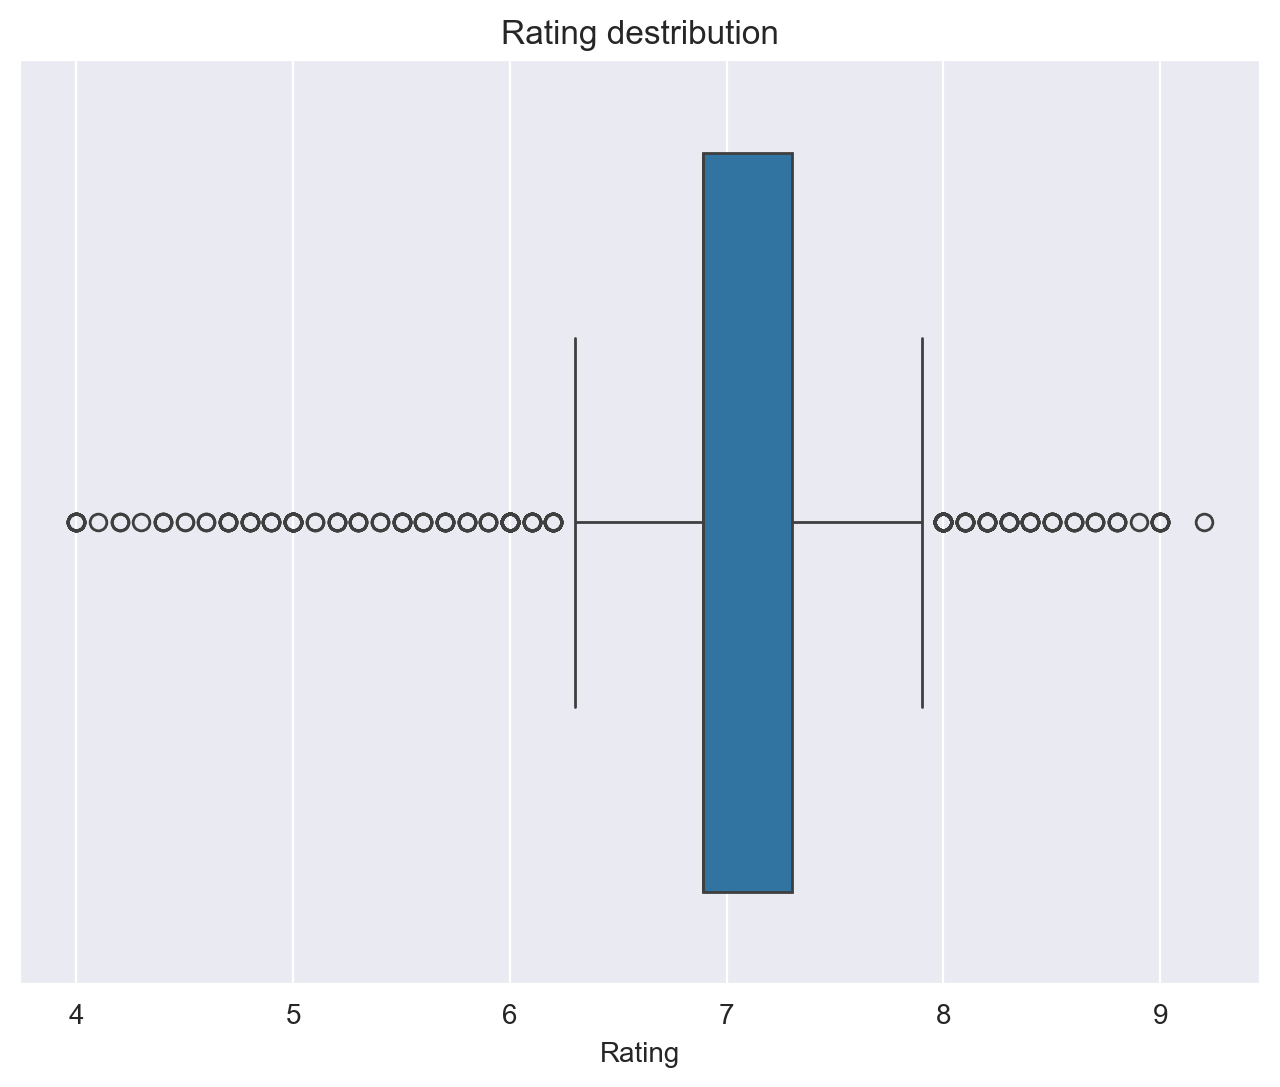

In [ ]:
df_filtered = df[df['rating'] != 0]
plt.figure(figsize=(8, 6))
sns.boxplot(x=df_filtered['rating'])
plt.title('Rating destribution')
plt.xlabel('Rating')
plt.show()
# выбросы

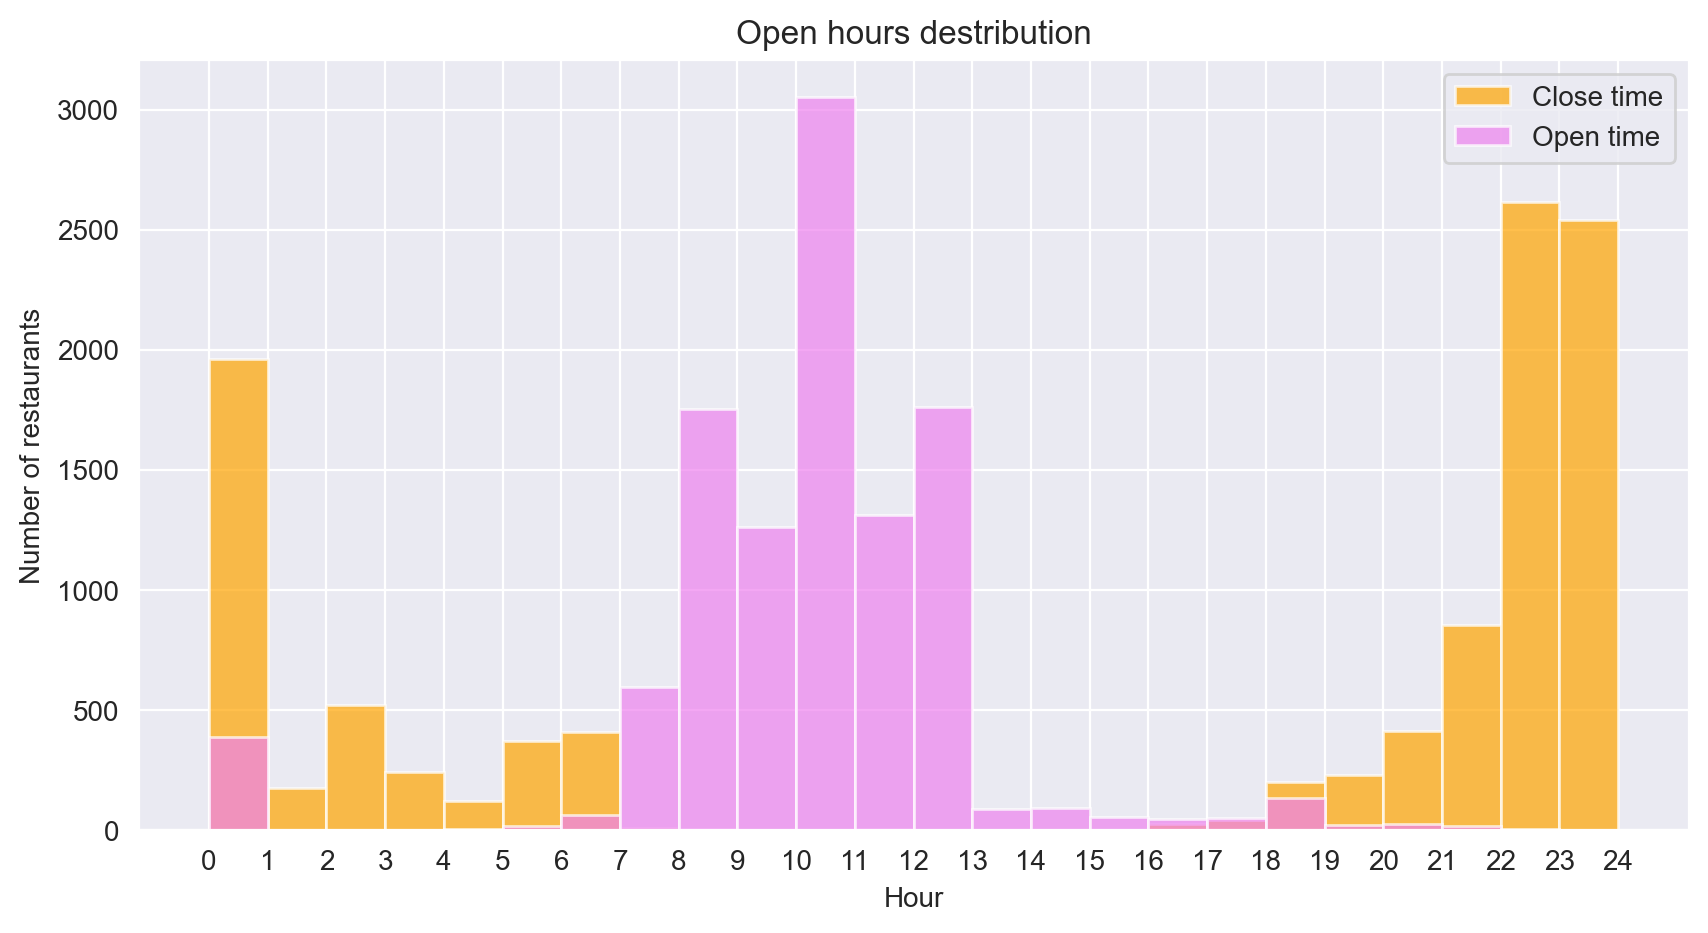

In [109]:
plt.figure(figsize=(10, 5))
plt.hist(df['opened_to_dttm'].apply(lambda x: x.hour), bins=24, range=(0, 24), alpha=0.7, label='Close time', color='orange')
plt.hist(df['opened_from_dttm'].apply(lambda x: x.hour), bins=24, range=(0, 24), alpha=0.7, label='Open time', color='violet')
plt.title('Open hours destribution')
plt.xlabel('Hour')
plt.ylabel('Number of restaurants')
plt.xticks(range(25))
plt.legend()
plt.show()

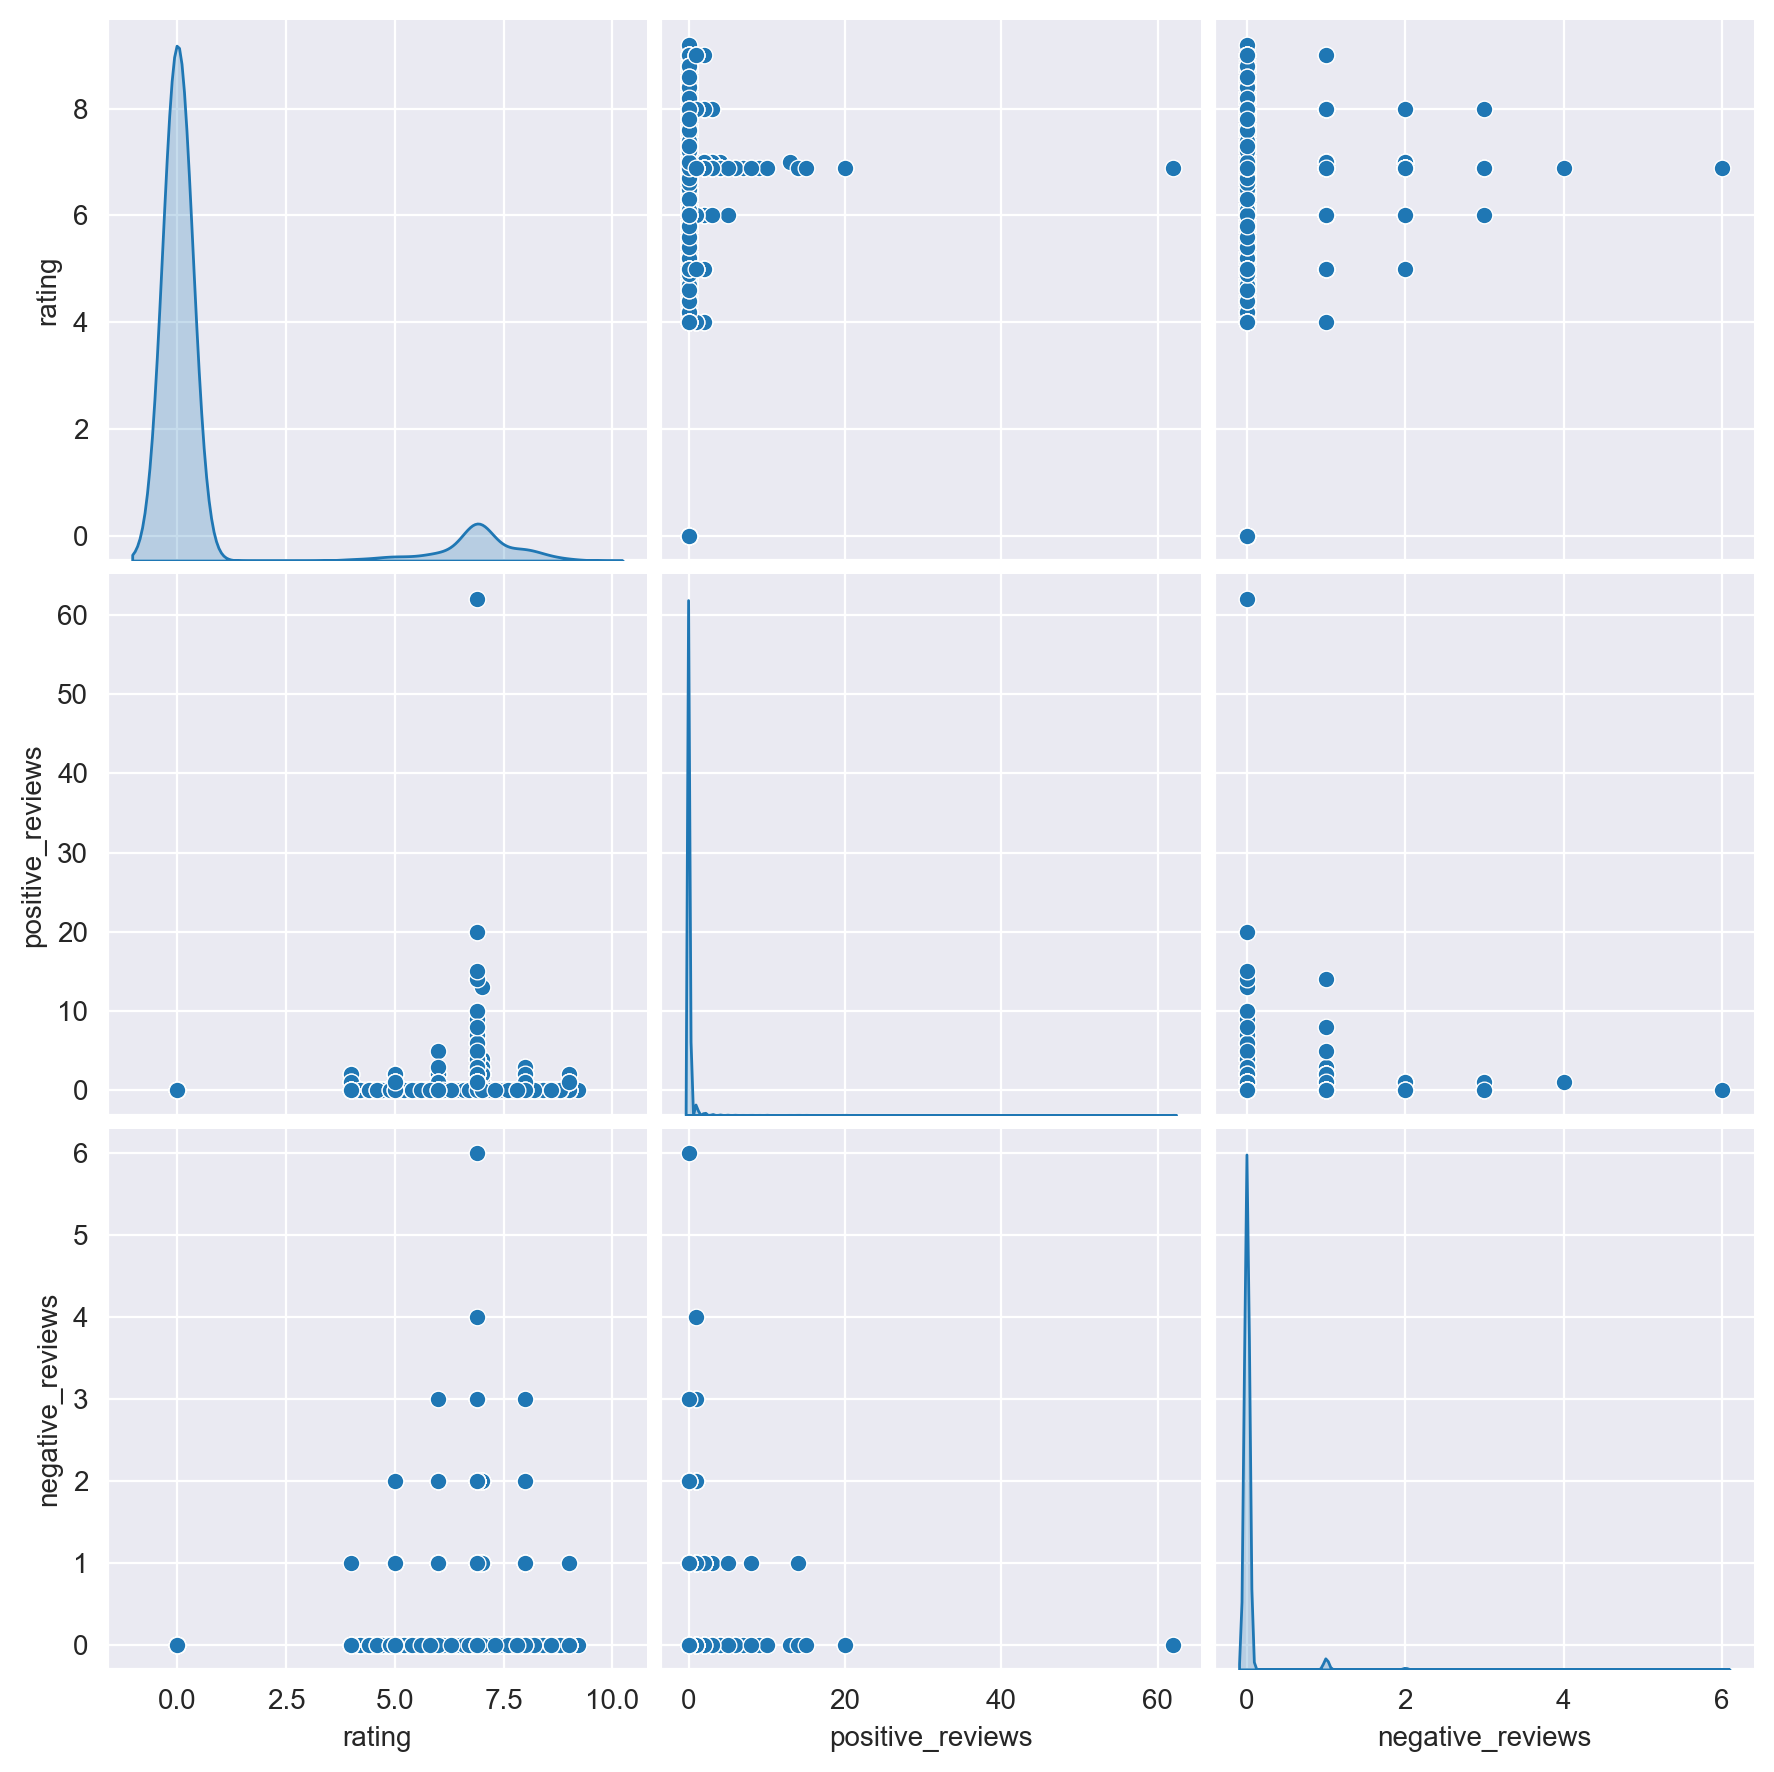

In [ ]:
sns.pairplot(df[['rating', 'positive_reviews', 'negative_reviews']], diag_kind='kde', height=3)
plt.show()
# 60 positive - выброс

Text(0, 0.5, 'Number of restaurants')

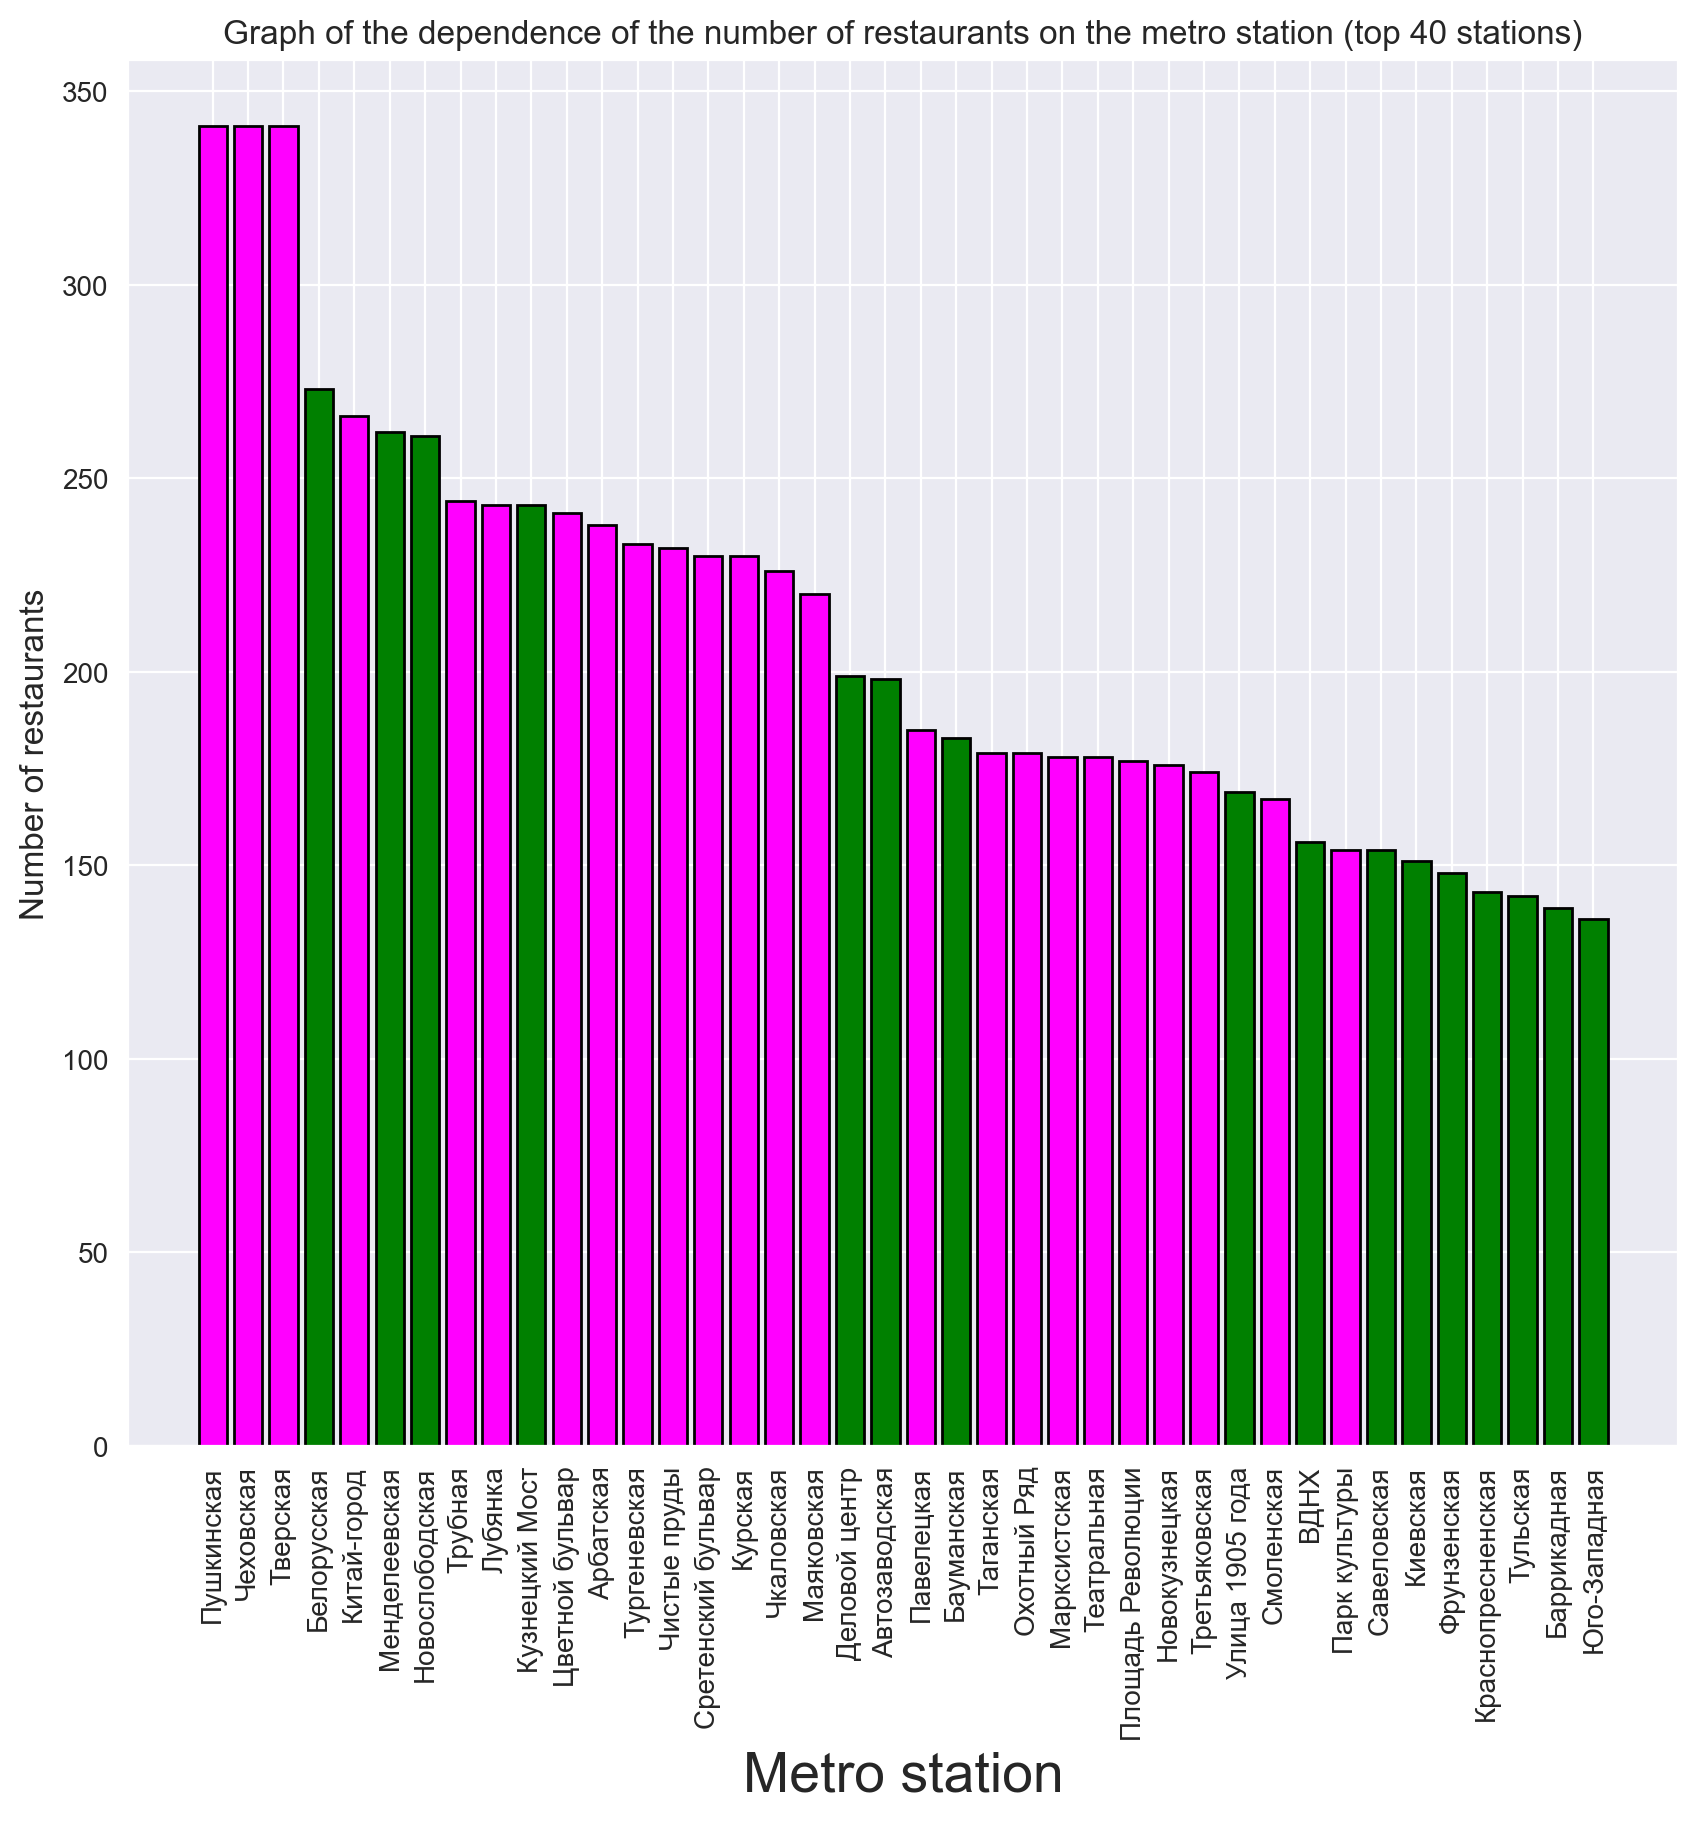

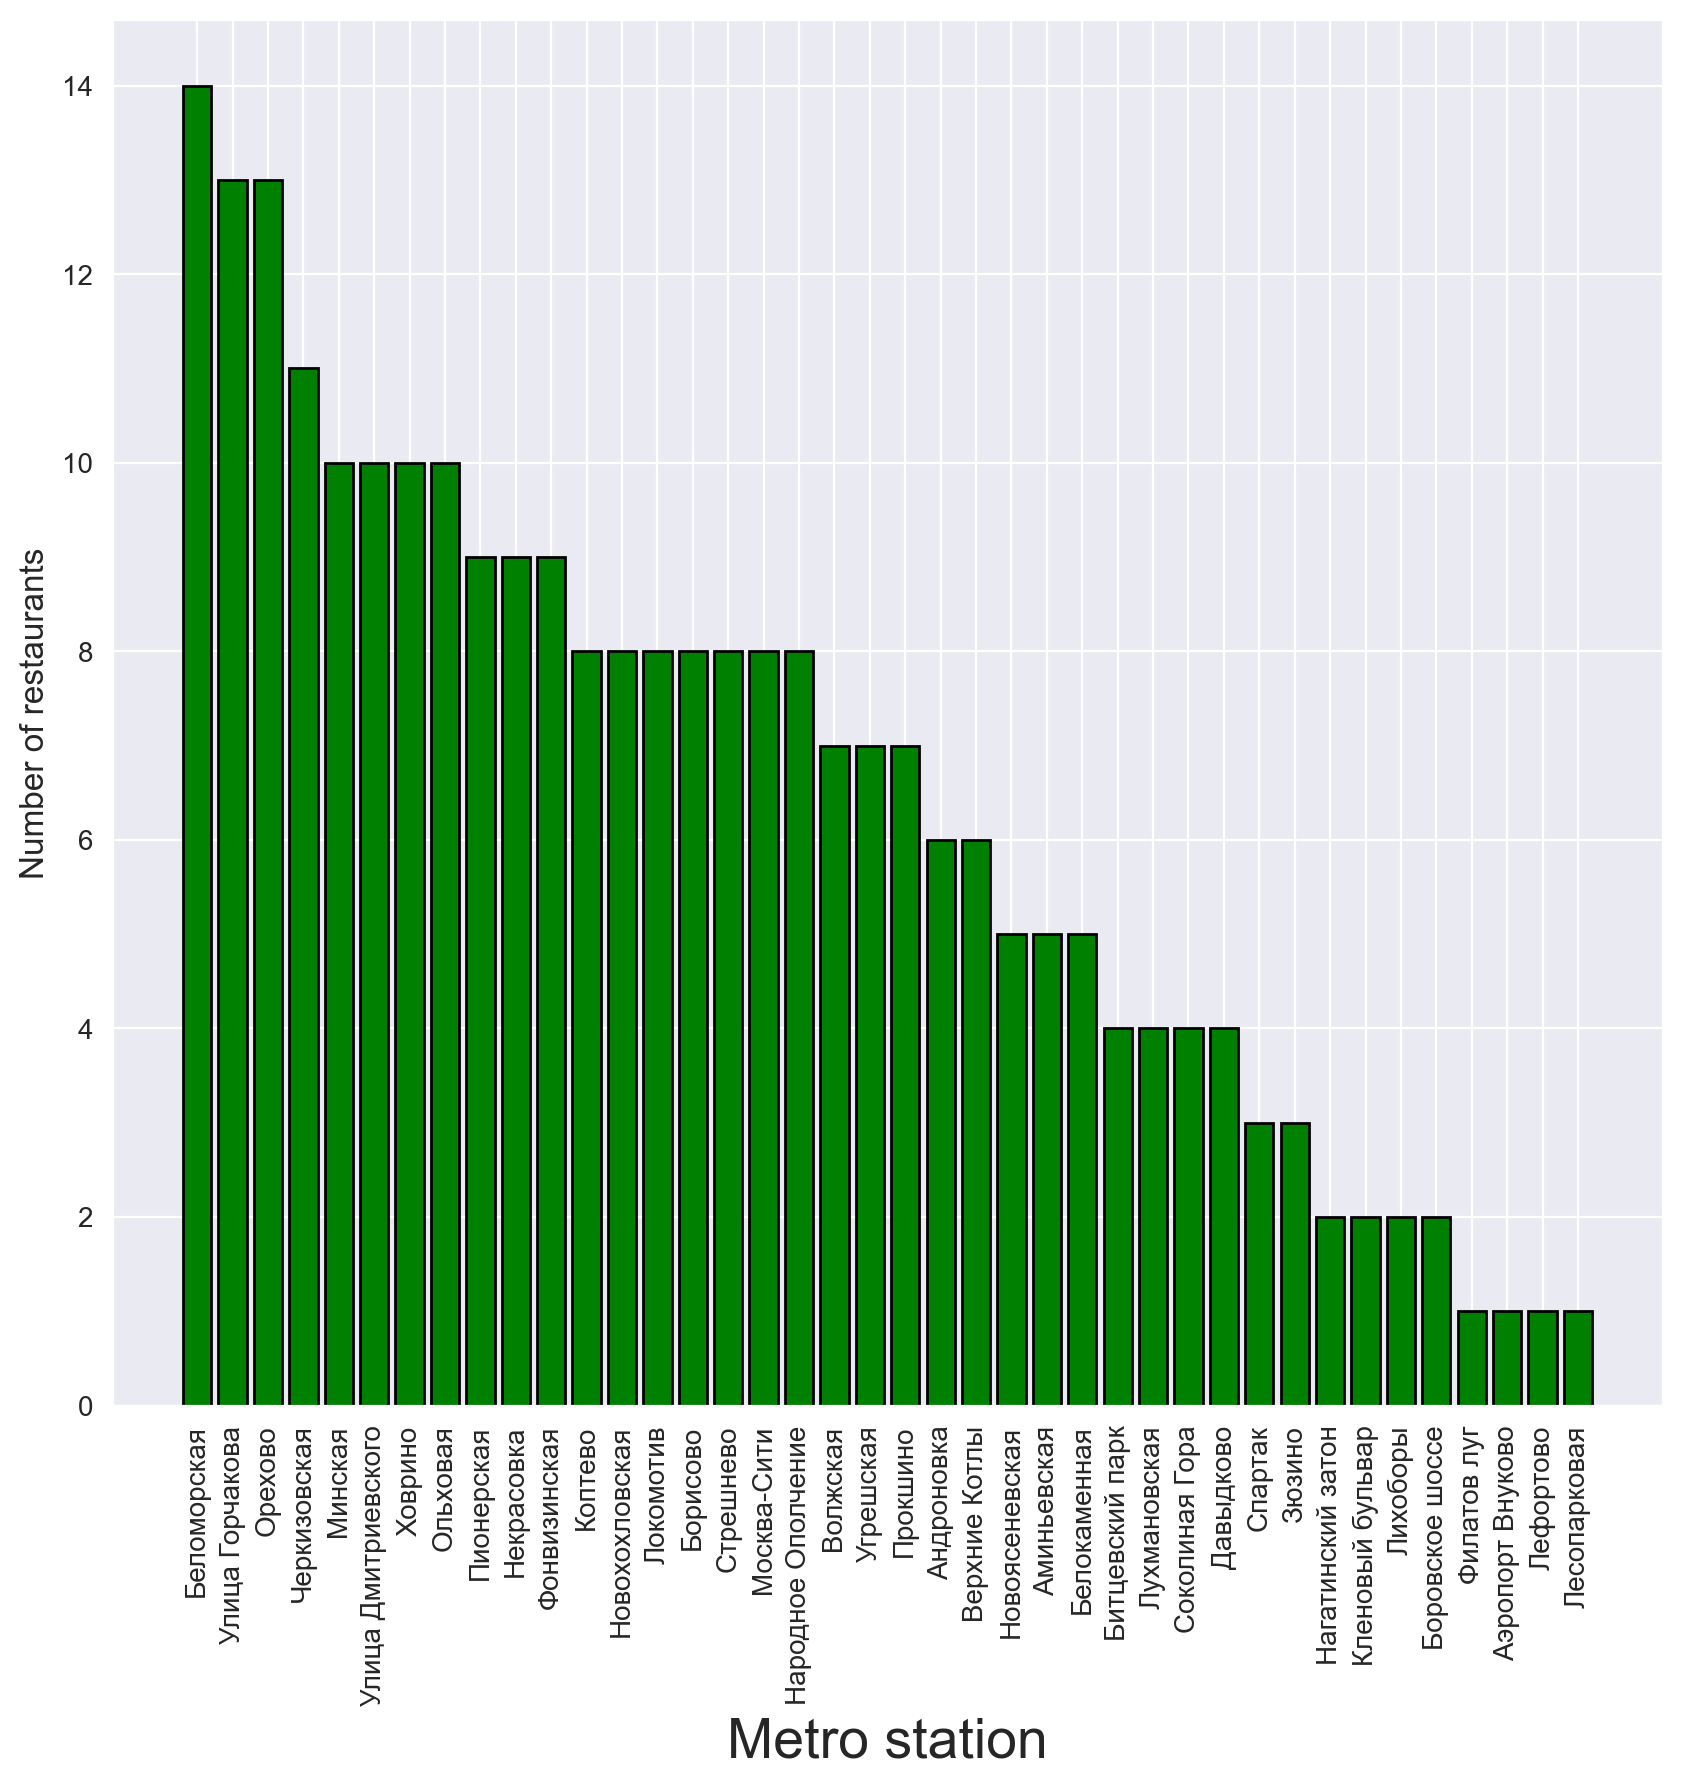

In [93]:
#сгруппировать методом groupby по станциям метро, а там потом посмотреть метро с наибольшим количеством ресторанов и с наименьшим количеством

metros = list(df['metro'].values)
metro_1=[]
for i in metros:
    metro_1 += [i[2:len(i)-2].split("', '")]
df['metro_new'] = metro_1   # новая колонка сгруппированая 

dg = df.explode('metro_new')

da = dg.groupby('metro_new')['title'].count().to_frame().reset_index(drop=False)
da1 = da.sort_values(by = 'title' , ascending=False)

metro_centr =['Цветной бульвар','Тверская','Чеховская','Боровицкая','Полянка', 'Добрынинская','Серпуховская','Маяковская','Театральная','Новокузнецкая','Павелецкая','Пушкинская','Кузнецкий мост','Китай-город','Таганская','Марксистская', 'Смоленская', 'Арбатская', 'Александровский сад', 'Площадь Революции', 'Чкаловская', 'Курская','Парк культуры','Кропоткинская','Библиотека им. Ленина','Охотный Ряд','Лубянка','Красные ворота','Чистые пруды','Красные ворота','Октябрьская','Третьяковская','Тургеневская','Сухаревская','Проспект Мира','Трубная','Сретенский бульвар'] 

da1_top=da1.head(40)
da1_top_1 = list(da1_top['metro_new'])
colors=[]
for i in da1_top_1:
    if i in metro_centr:
        colors +=['fuchsia']
    else:
        colors+=['green']  
            
#colors = ['fuchsia','fuchsia','fuchsia','green','fuchsia','green','green', 'fuchsia','fuchsia','fuchsia','fuchsia','fuchsia','fuchsia','fuchsia','fuchsia','fuchsia','fuchsia','fuchsia','green','green','fuchsia','green','fuchsia','fuchsia','fuchsia','fuchsia','fuchsia','fuchsia','fuchsia','fuchsia','fuchsia','green','fuchsia','green','green','green','green','green','green','green']
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 8, 5
plt.rcParams['font.size'] = 10
sns.set_style('darkgrid')

fig, ax = plt.subplots(1, 1, figsize=(10, 9)) 
plt.title('Graph of the dependence of the number of restaurants on the metro station (top 40 stations)')    
ax.set_xlabel('metro_new', fontsize=12)
ax.set_ylabel('title', fontsize=12)


plt.bar(da1_top.metro_new, da1_top.title, color=colors,edgecolor='black')
plt.xticks(rotation=90)
ax.set_xlabel('Metro station', fontsize=20) #подписываем оси
ax.set_ylabel('Number of restaurants', fontsize=12)

da1_end=da1.tail(40)
da1_end_1 = list(da1_end['metro_new'])
colors_1=[]
for i in da1_end_1:
    if i in metro_centr:
        colors_1 +=['fuchsia']
    else:
        colors_1+=['green'] 


fig, ax = plt.subplots(1, 1, figsize=(10, 9))     
ax.set_xlabel('metro_new', fontsize=12)
ax.set_ylabel('title', fontsize=12)

plt.bar(da1_end.metro_new, da1_end.title, color=colors_1,edgecolor='black')
plt.xticks(rotation=90)
ax.set_xlabel('Metro station', fontsize=20) #подписываем оси
ax.set_ylabel('Number of restaurants', fontsize=12)

Text(0, 0.5, 'Number of top restaurants')

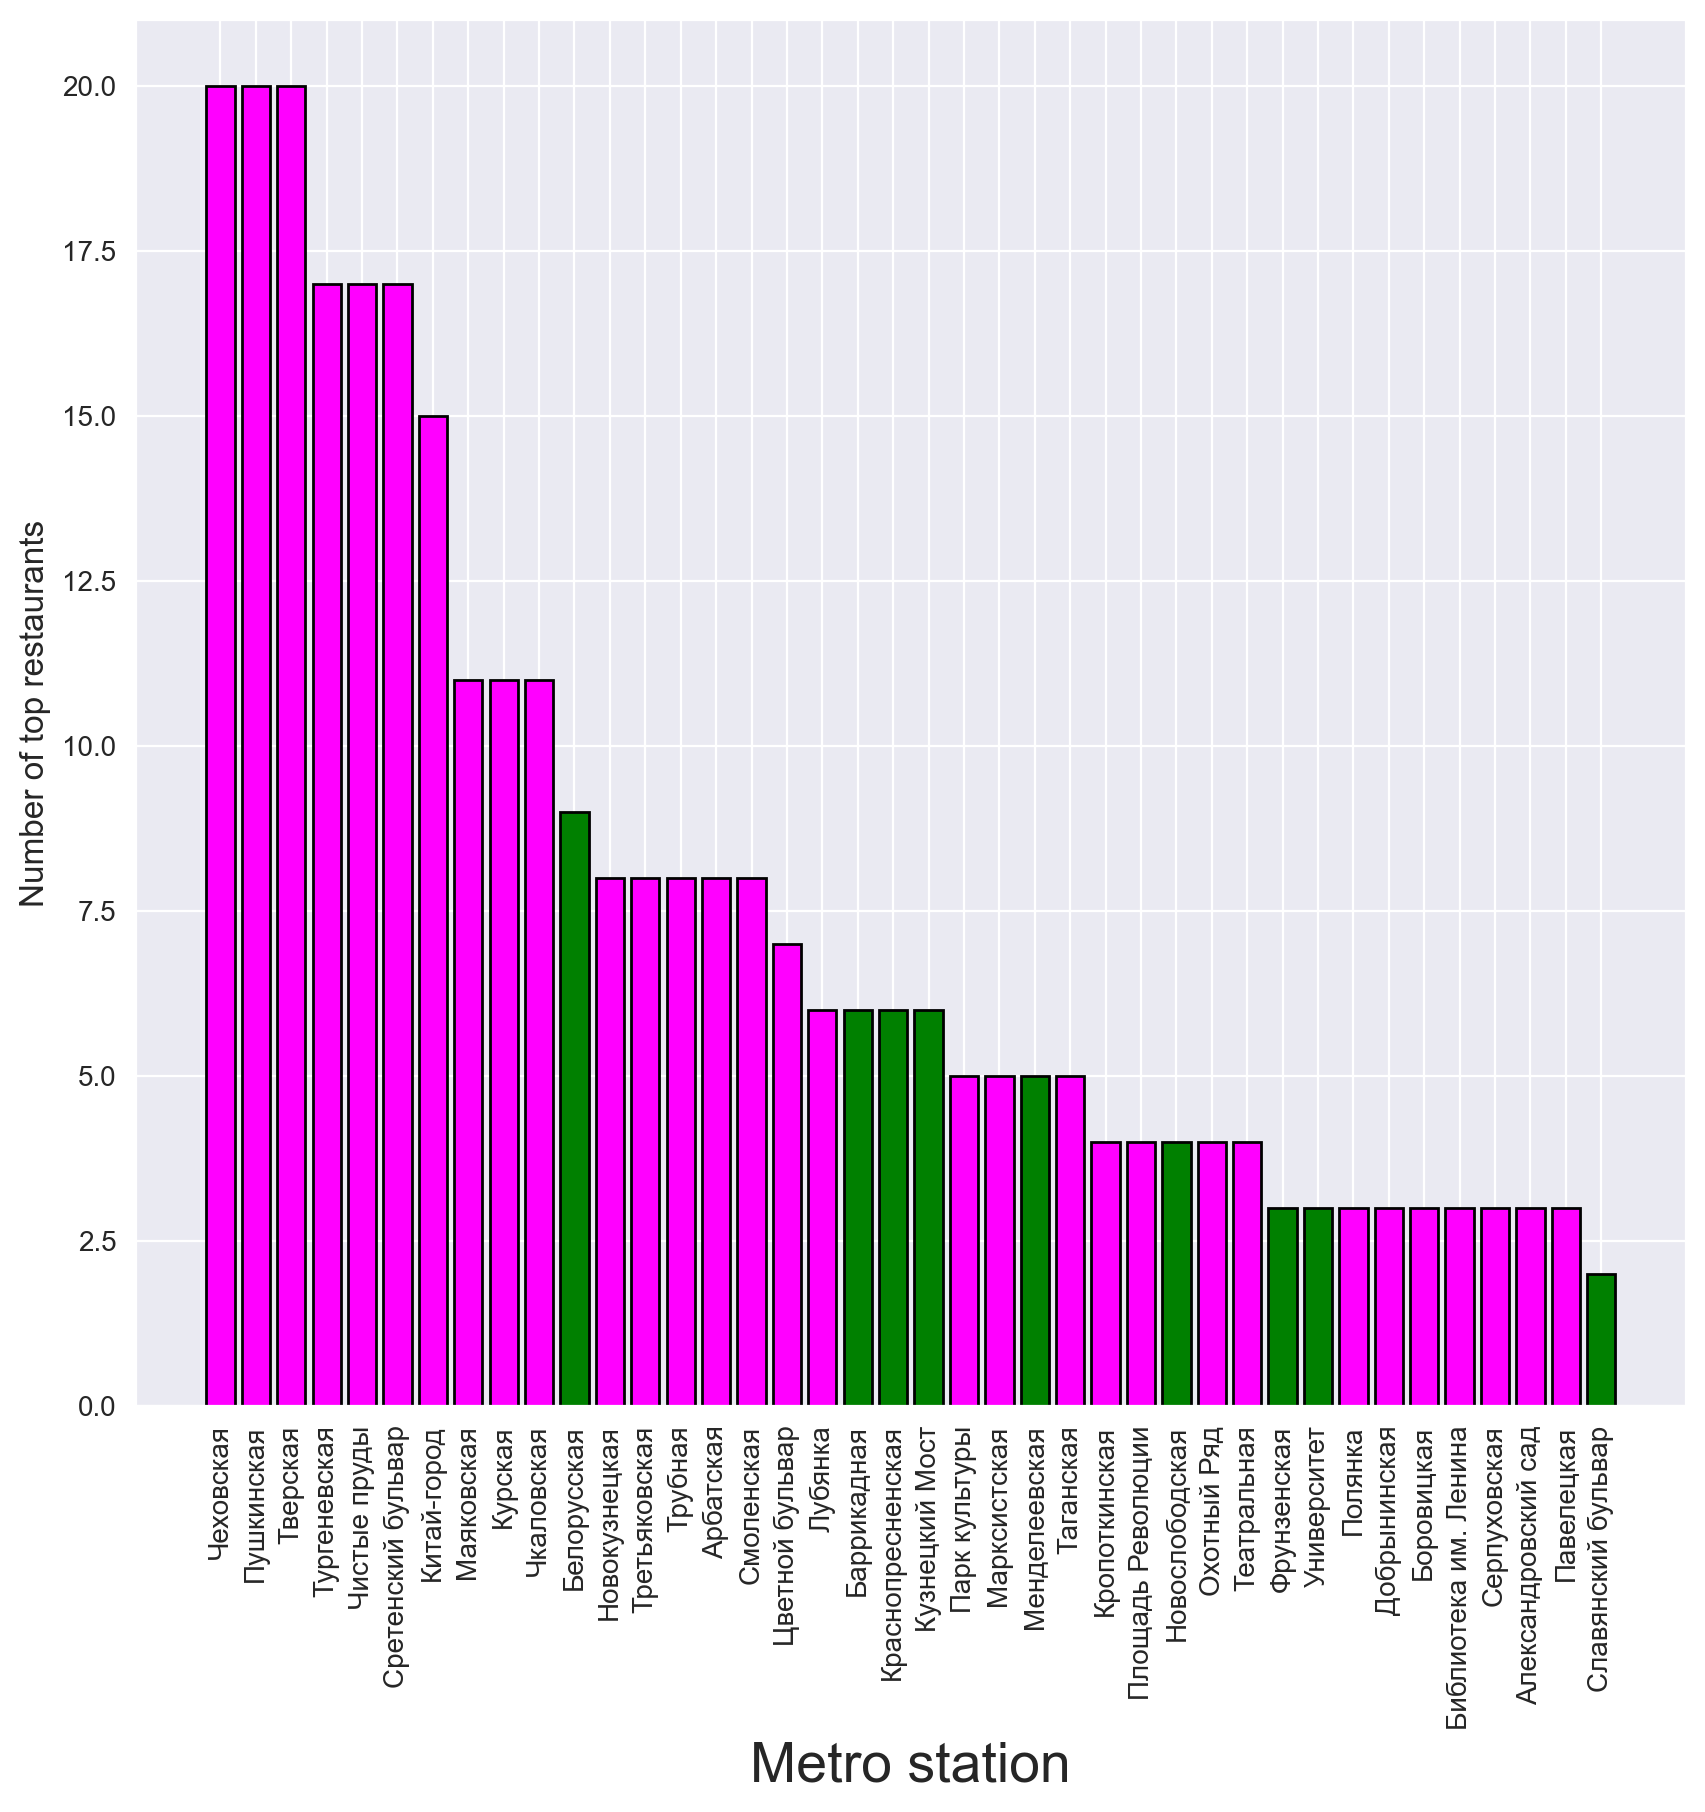

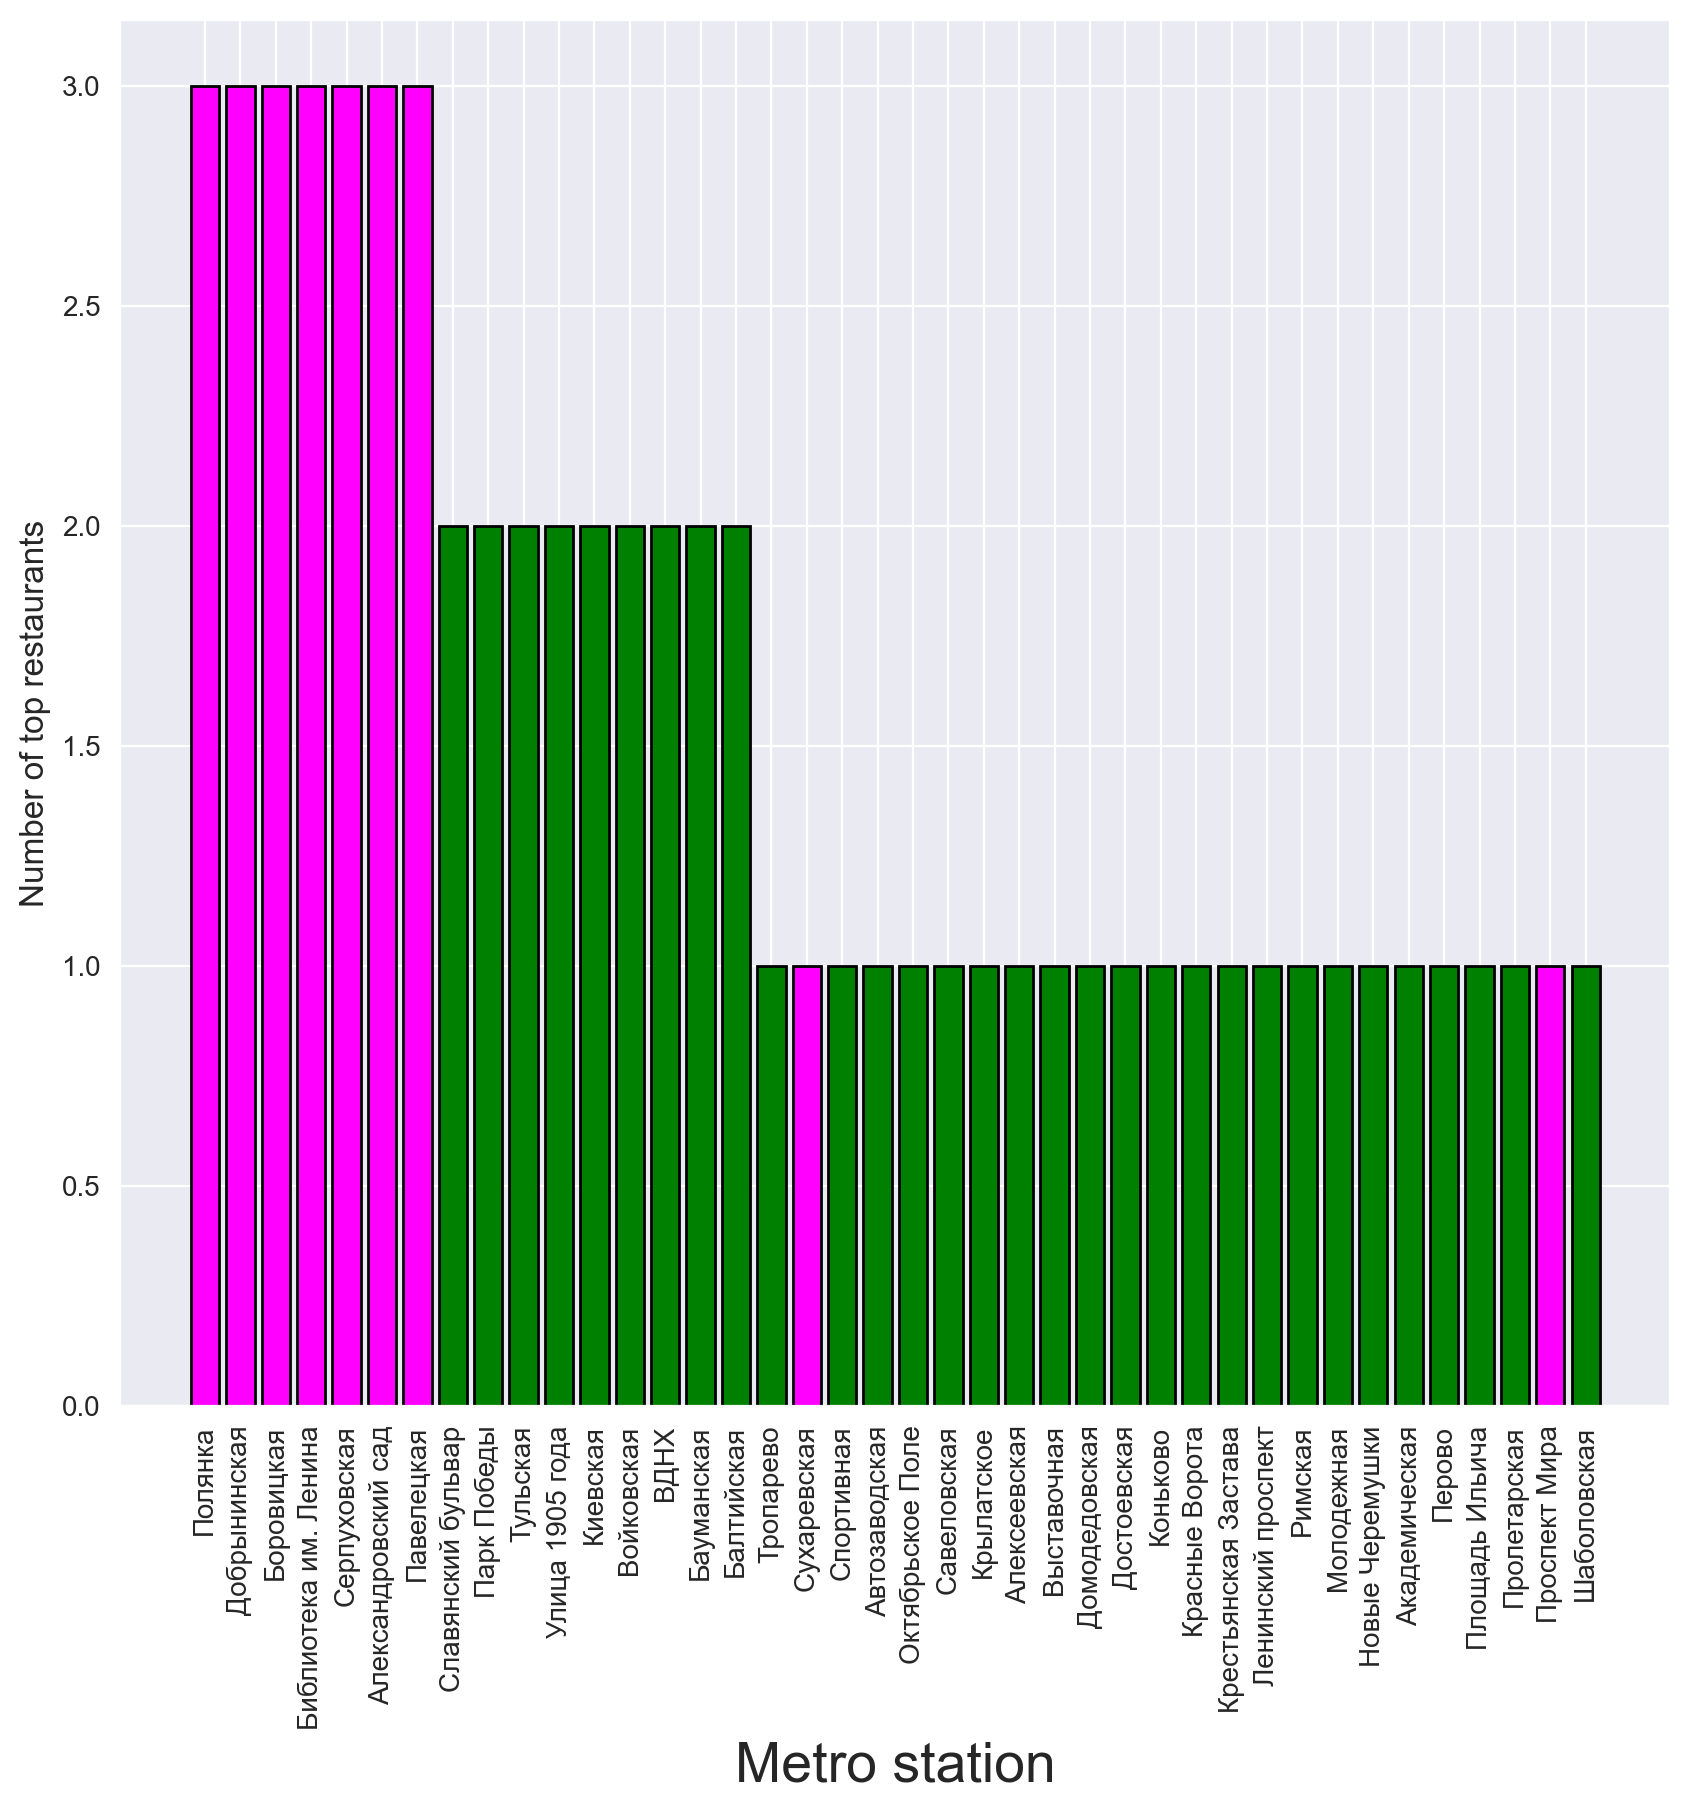

In [94]:
#сгруппировать методом groupby по станциям метро, а там потом посмотреть метро с наибольшим количеством ресторанов с отметкой top_restaurant и с наименьшим

da1 = dg[dg['top_restaurant'] == 1].groupby('metro_new')['title'].count().to_frame().reset_index(drop=False)
da2 = da1.sort_values(by = 'title' , ascending=False)
top_rest=da2.head(40)
top_rest_1 = list(top_rest['metro_new'])
colors_2=[]
for i in top_rest_1:
    if i in metro_centr:
        colors_2 +=['fuchsia']
    else:
        colors_2+=['green'] 

ig, ax = plt.subplots(1, 1, figsize=(10, 9))     
ax.set_xlabel('metro_new', fontsize=12)
ax.set_ylabel('title', fontsize=12)

plt.bar(top_rest.metro_new, top_rest.title, color=colors_2,edgecolor='black')
plt.xticks(rotation=90)
ax.set_xlabel('Metro station', fontsize=20) #подписываем оси
ax.set_ylabel('Number of top restaurants', fontsize=12)

top_end=da2.tail(40)
top_end_1 = list(top_end['metro_new'])
colors_3=[]
for i in top_end_1:
    if i in metro_centr:
        colors_3 +=['fuchsia']
    else:
        colors_3+=['green'] 

fig, ax = plt.subplots(1, 1, figsize=(10, 9))     
ax.set_xlabel('metro_new', fontsize=12)
ax.set_ylabel('title', fontsize=12)

plt.bar(top_end.metro_new, top_end.title, color=colors_3,edgecolor='black')
plt.xticks(rotation=90)
ax.set_xlabel('Metro station', fontsize=20) #подписываем оси
ax.set_ylabel('Number of top restaurants', fontsize=12)

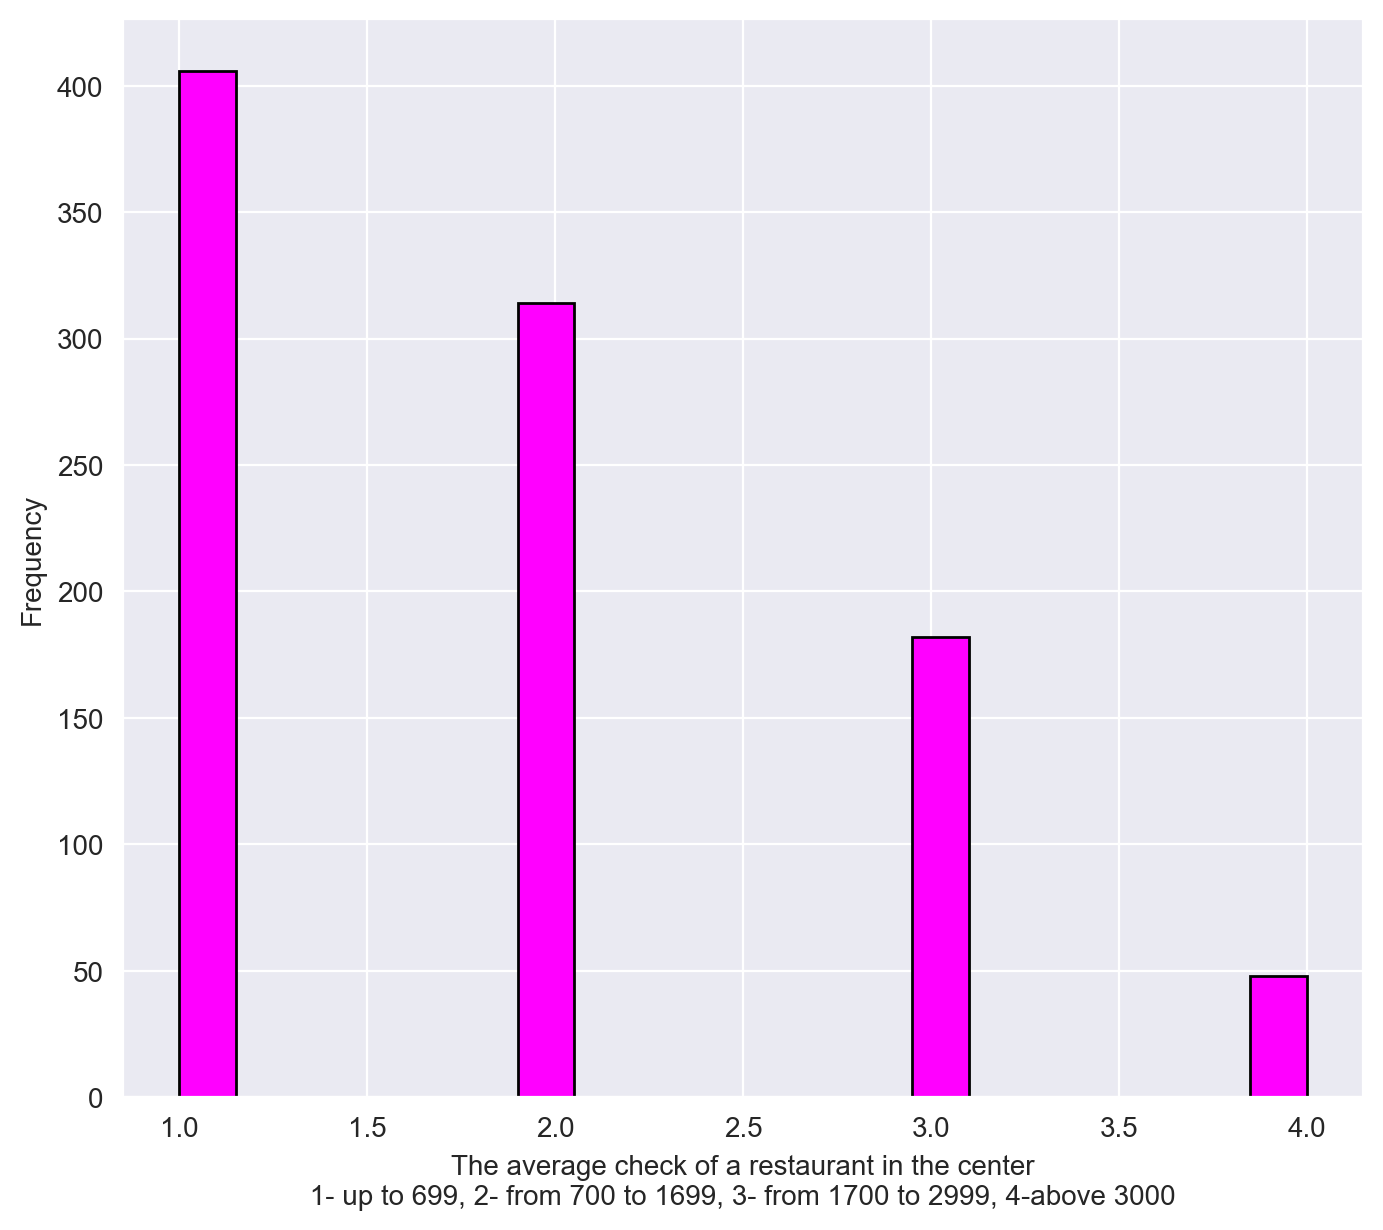

Text(0, 0.5, 'Frequency')

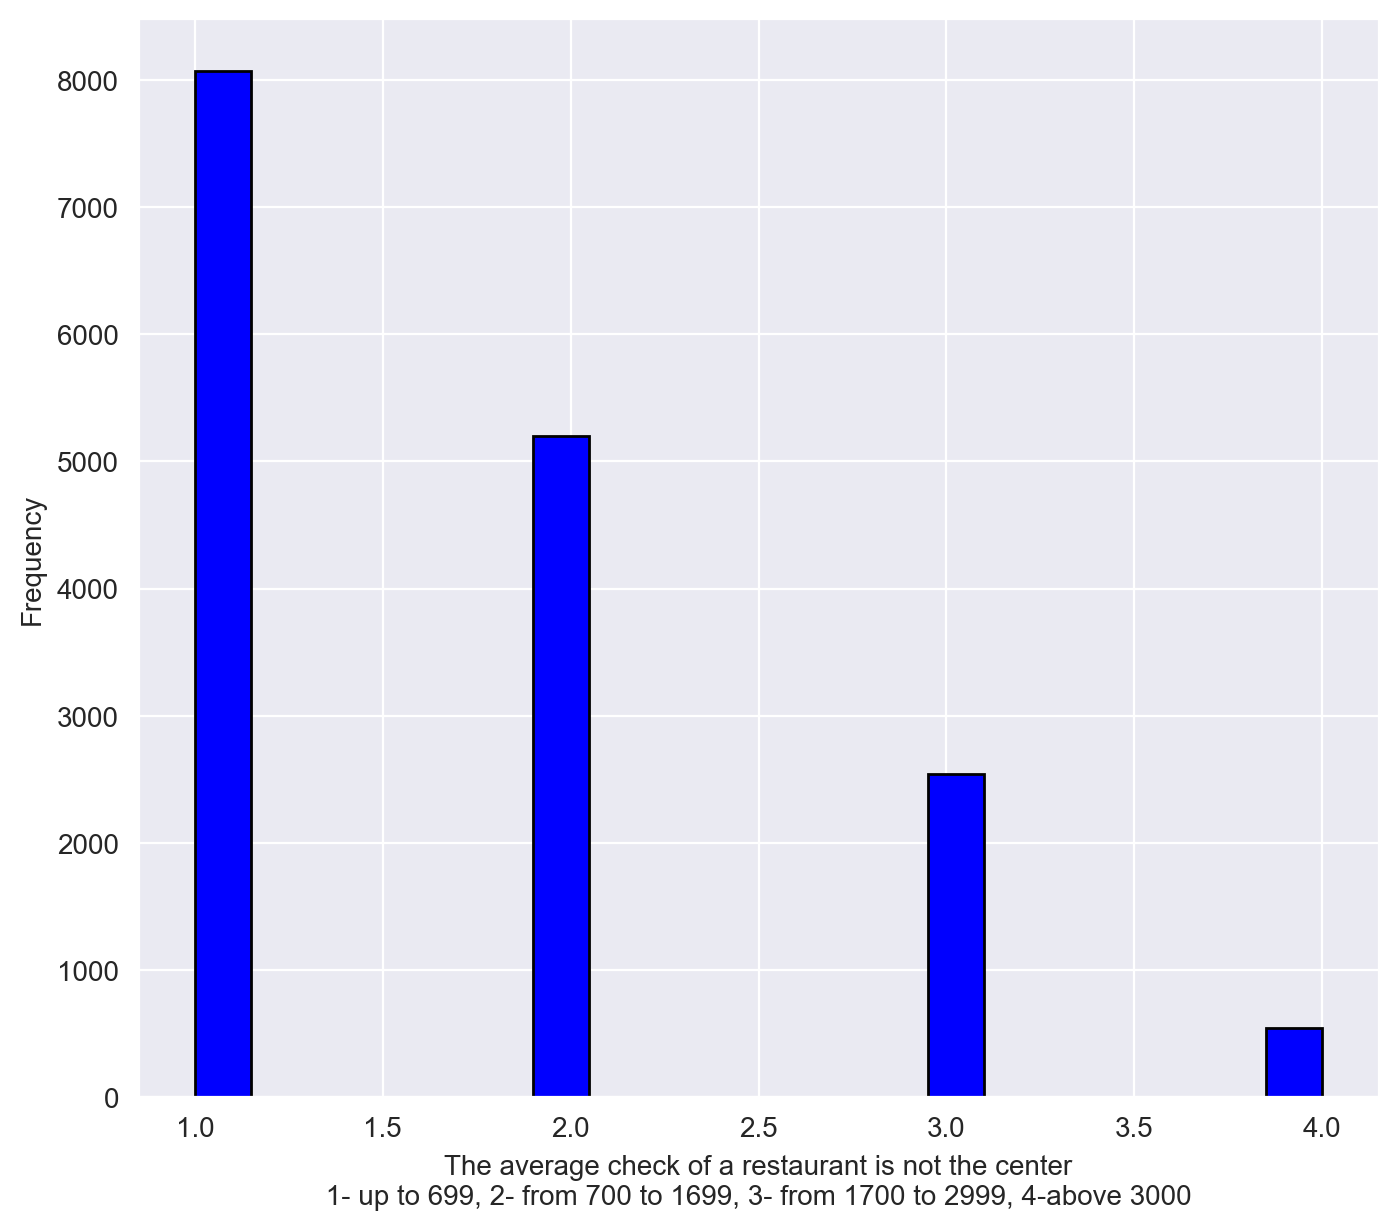

In [95]:
# сравнить распределение среднего чека в ресторанах в центре и распределение чека по ресторанам не в центре
new_centr = dg[dg['is_city_center']==1]
plt.figure(figsize=(8, 7))
plt.hist(new_centr['avg_check'],bins =20, color='fuchsia',edgecolor='black') 
plt.xlabel('The average check of a restaurant in the center\n 1- up to 699, 2- from 700 to 1699, 3- from 1700 to 2999, 4-above 3000 ',fontsize=10)#подписываем оси
plt.ylabel('Frequency',fontsize=10)
plt.show()
new_centr = dg[dg['is_city_center']==0]
plt.figure(figsize=(8, 7))
plt.hist(new_centr['avg_check'],bins =20, color='blue',edgecolor='black') 
plt.xlabel('The average check of a restaurant is not the center\n 1- up to 699, 2- from 700 to 1699, 3- from 1700 to 2999, 4-above 3000 ',fontsize=10)#подписываем оси
plt.ylabel('Frequency',fontsize=10)